# Business Cases - Case 3: Recheio


Project developed by:

- **Mara Mesquita** (20241039)  
- **Maria Assunção** (20211605)  
- **Martim António** (20240601)  
- **Pedro Catarro** (20230463)  
- **Victor Pita** (20240596)

# ``1. Imports``

## ``1.1. Libraries``

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

sns.set_style("white")
font_title = {'family': 'Calibri', 'color':  'black', 'weight': 'normal', 'size': 20}
font_label = {'family': 'Calibri', 'color':  'black', 'weight': 'normal', 'size': 13}

import datetime
import time
from sklearn.metrics import jaccard_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import random
import polars as pl

from surprise import Reader
from surprise import Dataset as Dataset2
from surprise import SVD, NMF, SlopeOne, KNNBasic, KNNWithMeans, KNNBaseline, CoClustering, BaselineOnly, NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection import ShuffleSplit  
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
import inspect

pd.set_option('display.max_rows', None)

## ``1.2. Datasets``

In [232]:
clients_df = pd.read_excel('Case3_Recheio_2025.xlsx', usecols='B,C,D', skiprows=1, sheet_name=0)
products_df = pd.read_excel('Case3_Recheio_2025.xlsx', usecols='B,C,D', skiprows=1, sheet_name=1)
transactions_df = pd.read_excel('Case3_Recheio_2025.xlsx', usecols='B,C,D', skiprows=1, sheet_name=2)

In [233]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6462 entries, 0 to 6461
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Client ID       6462 non-null   int64 
 1   ZIP Code        6462 non-null   int64 
 2   ID Client Type  680 non-null    object
dtypes: int64(2), object(1)
memory usage: 151.6+ KB


`ID Client Type` only has 680 records, which represent around 10,5% of data.

In [234]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4583 entries, 0 to 4582
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID Product           4583 non-null   int64 
 1   Product Description  4583 non-null   object
 2   ID Product Category  4583 non-null   object
dtypes: int64(1), object(2)
memory usage: 107.5+ KB


In [235]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884099 entries, 0 to 884098
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        884099 non-null  datetime64[ns]
 1   Client ID   884099 non-null  int64         
 2   ID Product  884099 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 20.2 MB


# ``2. Exploratory Data Analysis``

## ``2.1. Client``


In [236]:
clients_df.head()

,Client ID,ZIP Code,ID Client Type
0,210100002,4049,NaN
1,210100003,4000,NaN
2,210100004,4149,NaN
3,210100005,4100,Hotelaria
4,210100006,4405,NaN


We noticed is that there are 261 different ZIP codes and 26 different Client types. <br>
For the `ZIP Code`, we can get the location they relate to from the CTT website, here: 
* https://www.ctt.pt/feapl_2/app/open/postalCodeSearch/postalCodeSearch.jspx#fndtn-addressSearchPanel
* https://www.ctt.pt/feapl_2/app/restricted/postalCodeSearch/postalCodeDownloadFiles.jspx

Let's start by adding a `Location` to our clients dataframe, based on data collected externally from CTT.

In [237]:
locations_df = pd.read_csv("todos_cp.txt", sep = ";", header = None, encoding = "latin1")
locations_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,1,249,Alcafaz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3750,11,AGADÃO
1,1,1,250,Caselho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3750,12,AGADÃO
2,1,1,251,Corga da Serra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3750,13,AGADÃO
3,1,1,252,Foz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3750,14,AGADÃO
4,1,1,253,Guistola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3750,15,AGADÃO


In [238]:
zip_location_dict = dict(zip(locations_df[14], locations_df[16]))
clients_df["Location"] = clients_df["ZIP Code"].map(zip_location_dict)
clients_df.head()

,Client ID,ZIP Code,ID Client Type,Location
0,210100002,4049,NaN,PORTO
1,210100003,4000,NaN,PORTO
2,210100004,4149,NaN,PORTO
3,210100005,4100,Hotelaria,PORTO
4,210100006,4405,NaN,VILA NOVA DE GAIA


In [239]:
clients_df.nunique()

Client ID         6462
ZIP Code           261
ID Client Type      26
Location           187
dtype: int64

In [240]:
# location distribution
clients_df['Location'].value_counts()


PORTO                        2417
VILA NOVA DE GAIA             590
MATOSINHOS                    345
MAIA                          306
LISBOA                        250
RIO TINTO                     143
PÓVOA DE VARZIM               132
SENHORA DA HORA               109
VILA DO CONDE                  98
ERMESINDE                      95
VILAR VCD                      84
SANTA CRUZ DO BISPO            82
VALBOM GDM                     76
SÃO MAMEDE DE INFESTA          72
MOSTEIRÓ VFR                   62
FONTE ARCADA PNF               60
OUTIZ                          59
GEMESES                        59
SÃO PAIO DE OLEIROS            54
SERZEDO VNG                    49
SÃO JOÃO DA MADEIRA            43
SÃO PEDRO DA COVA              42
CERNADELO                      42
VALONGO                        40
NOGUEIRA DA REGEDOURA          39
S VICENTE DE PEREIRA JUSÃ      38
SEQUEIRÓ                       38
TROFA                          38
SERMONDE                       38
BRAGA         

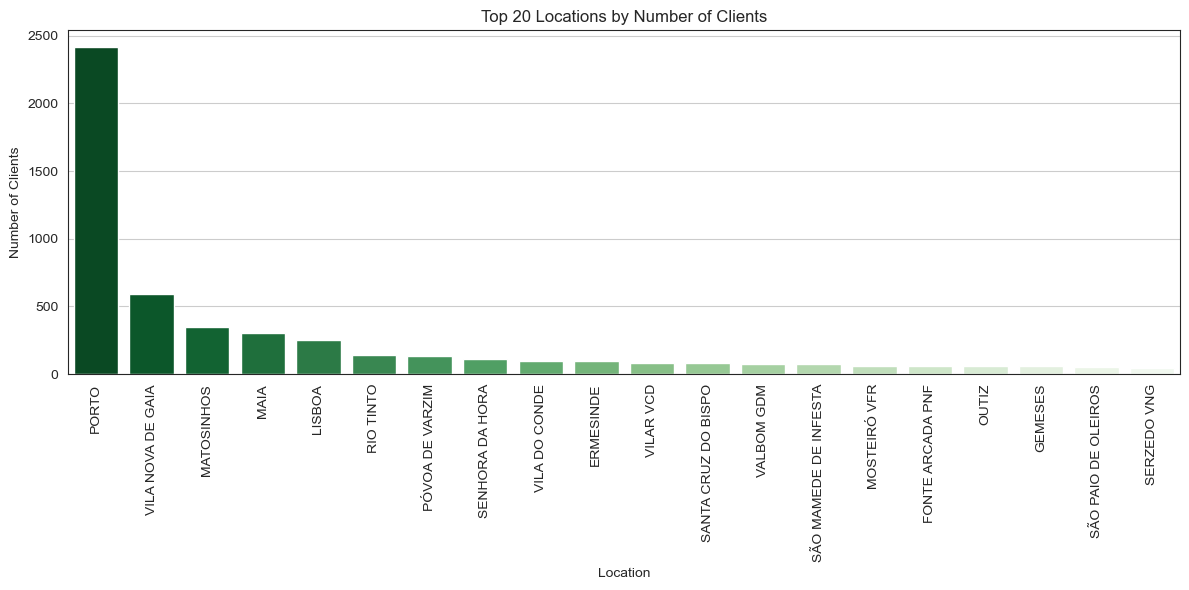

In [241]:
location_counts = clients_df["Location"].value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=location_counts.index, y=location_counts.values, palette="Greens_r")
plt.title("Top 20 Locations by Number of Clients")
plt.xlabel("Location")
plt.ylabel("Number of Clients")
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

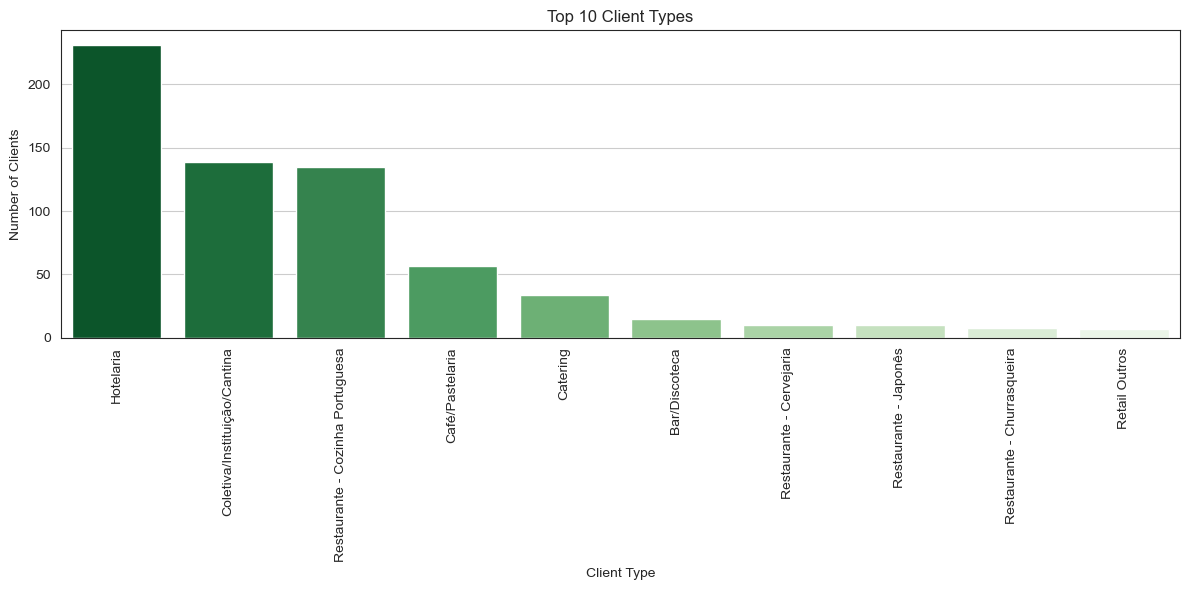

In [242]:
clients_df_filtered = clients_df[clients_df["ID Client Type"].notna() & (clients_df["ID Client Type"] != "Unknown")]

# count and plot
client_type_counts = clients_df_filtered["ID Client Type"].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=client_type_counts.index, y=client_type_counts.values, palette="Greens_r")
plt.title("Top 10 Client Types")
plt.xlabel("Client Type")
plt.ylabel("Number of Clients")
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

Insights from Client Location and Client Type Distributions

1. Location Distribution
From the analysis of client locations, we observed that:

- The majority of clients are concentrated in a few key cities:
  - **Porto** is by far the most represented location, with **2,417 clients**, followed by **Vila Nova de Gaia** (590) and **Matosinhos** (345).
  - Other important cities include **Maia**, **Lisboa**, and **Rio Tinto**.
- After the top cities, the number of clients per location decreases quickly, showing a **long tail** distribution.
- Many locations have only a handful of clients (some just 1 or 2), suggesting a highly geographically dispersed client base.

**What this tells us:**  
- Our recommendation strategies could initially focus more on clients located in the Porto metropolitan area, given the high client density.
- For less populated regions, we might need different strategies (e.g., more generalized recommendations).

---

2. Client Type Distribution
Regarding the `ID Client Type`, we found that:

- A very large portion of clients (almost **5782**) have their type marked as **Unknown**.
- Among the classified clients, the most frequent types are:
  - **Hotelaria** (231 clients)
  - **Coletiva/Instituição/Cantina** (139 clients)
  - **Restaurante - Cozinha Portuguesa** (135 clients)
  - **Café/Pastelaria** (57 clients)
- Specialized restaurant types (e.g., **Japonês**, **Cervejaria**, **Churrasqueira**) are present but in much smaller numbers.

**What this tells us:**  
- The data suffers from a significant amount of missing values in Client Type, which limits direct segmentation.
- Nevertheless, the available types show that Recheio’s client base is strongly associated with the **HoReCa sector** (Hotels, Restaurants, and Cafés).
- We might explore if Unknown clients in Porto and Gaia behave similarly to Hotelaria or Restaurante clients, which could help in imputing or better segmenting the data.


## ``2.2. Product``

In [243]:
products_df.nunique()

ID Product             4583
Product Description    4573
ID Product Category     268
dtype: int64

In [244]:
products_df['Product Description'].value_counts()

CABO ESFREGONA VILEDA SUPER 1UN             2
AREIAS DE MANTEIGA 300 G                    2
CREME VEGETAL MCHEF KG                      2
FEIJÃO PRETO CISTER BOLSA 3/1,8 KG          2
V.DOURO CALLABRIGA TTO 75CL                 2
DIP POT MOLHO ALHO HEINZ 100X 25GR          2
PHILADELPHIA  REGULAR 2KG                   2
MISTURA SOLÚVEL MOKAMBO 200G                2
TAB CHOC LEITE TOBLERONE 35G                2
V DOURO MONTES ERMOS COLHEITA TTO 75CL      2
MUFFINS MÁRMOR CÉLIANE S/GLUTEN 210G        1
BOV LOMBO 3/4 URUGUAI CONG. KG              1
CHÁ EARL GREY LIPTON 25UN                   1
GRD DELÍCIA FRUT SILV CPROF2.85K(74616)     1
CHOCO MUESLI HAMMERMHULE 350G S/GLUTEN      1
BOL CRACKER LU TUC ORIGIN 100G              1
BISCOITO AMANHECER TRA INT SOJA LIM 250G    1
QUEIJO ROQUEFORT DOP SOCIÉTÉ METADES KG     1
CHOCOLATE PO IMPERIAL 1KG                   1
BOLACHA LEQUE PROGELCONE 1KG                1
QUEIJO MANCHEGO DOP VILLACENTENO 250G       1
MIN.TORTITAS MIL.AMANH C/S 200    

Based on discussions with Recheio, we found that it’s not uncommon for identical products to have multiple `Product ID`s. This usually happens when packaging is updated or when a new supplier version is introduced. Even if the core product remains the same, Recheio treats it as a distinct item in the system, assigning a new ID. During the data preprocessing phase, we plan to consolidate such cases by replacing outdated `Product ID`s with the most recent one. This approach ensures that we don’t end up recommending discontinued items while still capturing the customer’s past interest in the product.



Moving forward, we aim to identify which `Product Category` appears most frequently in the dataset. To support this analysis visually, we will create a bar chart that highlights the distribution of products across categories.


In [245]:
category_counts = products_df["ID Product Category"].value_counts()

fig = px.bar(
    y=category_counts.index,
    x=category_counts.values,
    orientation='h',  # Horizontal bars
    text=category_counts.values,
    color=category_counts.index,
    color_discrete_sequence=["forestgreen"],
    labels={"x": "Count", "y": "Product Category"},
    title="Product Categories Distribution"
)

fig.update_layout(
    title_x=0.5,
    height=800,
    template="plotly_white",
    showlegend=False
)

fig.update_traces(textposition='outside')
fig.show()


 Insights from Product Category Distribution

1. Strong Long Tail Distribution
From the chart, we observed a clear long-tail pattern in the distribution of product categories:
- A small number of categories such as **VINHOS TINTOS**, **BOVINO**, and **MASSAS** dominate the catalog.
- The majority of categories appear only a few times, indicating a high level of product diversity and specialization.

**What this means for us:**  
We need to be cautious when building our recommendation models, as there's a risk of bias towards the most frequent categories. We will consider implementing mechanisms that ensure recommendation diversity.

---

2. Presence of Highly Specific or Niche Categories
We identified several niche categories, such as:
- **ERVILHAS**, **FUNDIDO**, **MASSAS CULINARIA**, **PAPEL VEGETAL**

These categories could lead to sparsity issues in collaborative filtering models due to low interaction volume. We plan to complement collaborative methods with **content-based recommendations**, leveraging product descriptions and textual similarity.

---

3. Auxiliary or Possibly Irrelevant Categories
Some product categories are ambiguous and may not make sense in a typical recommendation context. Examples include:
- **0**
- **ARTIGOS DESCONTO**
- **MENU**

Later, we intend to flag these categories and evaluate whether they should be excluded or handled separately based on the final use case of our system.

---

4. Strategic Use of Top Categories
The most common categories in our dataset, such as **VINHOS TINTOS**, **MASSAS**, and **XAROPES**, represent key areas where we can:
- Build effective cold-start recommendations.
- Segment users based on frequent purchases.
- Highlight trending or seasonal items for dynamic suggestion modules.

We will use these as starting points in our initial modeling phase.

---

5. Simplification and Reorganization of Categories
Given the high granularity in some areas of the dataset, we believe it's worth creating a **“Broad Category”** grouping. For instance:
- `BACALHAU`, `PESCADO SELVAGEM`, and `BIVALVES` could be grouped under **PEIXES E MARISCOS**
- `DOCES E CREMES PARA BARRAR` and `BOLOS E SOBREMESAS INDIVIDUAIS` under **SOBREMESAS**

This would simplify our modeling process and help us draw stronger patterns in user behavior.



## ``2.3. Transactions``

In [246]:
transactions_df.shape

(884099, 3)

In [247]:
# checking duplicates
duplicate_rows = transactions_df[transactions_df.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
             Date  Client ID  ID Product
104615 2022-03-01  210100804      904364
105040 2022-03-01  210102196      521205
105329 2022-03-01  210103577      931201
105452 2022-03-01  210103706      935622
106122 2022-03-01  210104607      372332
106311 2022-03-01  210105057      621958
107265 2022-03-01  210105808      906995
107505 2022-03-01  210105969      701988
107508 2022-03-01  210105969      931201


In [248]:
transactions_df = transactions_df.drop_duplicates()

In [249]:
transactions_df.shape

(884090, 3)

Since these 9 records are duplicated information, they will be dropped to avoid redundancy.

In [250]:
full_df_exploration = pd.merge(transactions_df, clients_df, on = "Client ID", how = "left")
full_df_exploration = pd.merge(full_df_exploration, products_df, on = "ID Product", how = "left")
full_df_exploration.head()

,Date,Client ID,ID Product,ZIP Code,ID Client Type,Location,Product Description,ID Product Category
0,2022-01-02,210100281,224780,4400,Café/Pastelaria,VILA NOVA DE GAIA,FARINHA ESPIGA AMIDO MILHO LUS.2KG,FARINHAS
1,2022-01-02,210100281,276806,4400,Café/Pastelaria,VILA NOVA DE GAIA,LARANJA CAL7 (67/76) RCH,FRUTAS FRESCAS
2,2022-01-02,210100281,276809,4400,Café/Pastelaria,VILA NOVA DE GAIA,LIMAO CAL 3/4 RCH,FRUTAS FRESCAS
3,2022-01-02,210100281,277674,4400,Café/Pastelaria,VILA NOVA DE GAIA,COGUMELO BRANCO MÉDIO RCH,LEGUMES FRESCOS
4,2022-01-02,210100281,277917,4400,Café/Pastelaria,VILA NOVA DE GAIA,TOMATE BB 67/82 1CAM RCH,LEGUMES FRESCOS


In [251]:
full_df_exploration = full_df_exploration.sort_values(by='Date')
full_df_exploration['Semester'] = np.where(full_df_exploration['Date'].dt.month <= 6, 1, 2)
full_df_exploration['Quarter'] = (full_df_exploration['Date'].dt.month - 1) // 3 + 1
full_df_exploration['Month'] = full_df_exploration['Date'].dt.month
full_df_exploration['Month'] = full_df_exploration['Month'].astype(str).str.zfill(2)
full_df_exploration['Day'] = full_df_exploration['Date'].dt.day
full_df_exploration['Day'] = full_df_exploration['Day'].astype(str).str.zfill(2)
full_df_exploration["Week Day"] = full_df_exploration["Date"].dt.day_name()
full_df_exploration.head()

,Date,Client ID,ID Product,ZIP Code,ID Client Type,Location,Product Description,ID Product Category,Semester,Quarter,Month,Day,Week Day
0,2022-01-02,210100281,224780,4400,Café/Pastelaria,VILA NOVA DE GAIA,FARINHA ESPIGA AMIDO MILHO LUS.2KG,FARINHAS,1,1,01,02,Sunday
1031,2022-01-02,210105468,101581,4000,NaN,PORTO,CALDO GALINHA KNORR PASTAKG,CONDIMENTOS,1,1,01,02,Sunday
1030,2022-01-02,210105450,932725,4434,NaN,VILA NOVA DE GAIA,ÁGUA AMANHECER NASCENTE PET 6LT,ÁGUAS LISAS,1,1,01,02,Sunday
1029,2022-01-02,210105450,865246,4434,NaN,VILA NOVA DE GAIA,QUEIJO MOZZARELLA FIOS ARLA PRO 2KG,MOZZARELLA,1,1,01,02,Sunday
1028,2022-01-02,210105450,851557,4434,NaN,VILA NOVA DE GAIA,OVOS NOSTRUM CLASSE L CARTAO 15 DZ IND,OVOS GAIOLA,1,1,01,02,Sunday


In [252]:
full_df_exploration.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884090 entries, 0 to 884089
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 884090 non-null  datetime64[ns]
 1   Client ID            884090 non-null  int64         
 2   ID Product           884090 non-null  int64         
 3   ZIP Code             884090 non-null  int64         
 4   ID Client Type       389813 non-null  object        
 5   Location             881591 non-null  object        
 6   Product Description  884090 non-null  object        
 7   ID Product Category  884090 non-null  object        
 8   Semester             884090 non-null  int32         
 9   Quarter              884090 non-null  int64         
 10  Month                884090 non-null  object        
 11  Day                  884090 non-null  object        
 12  Week Day             884090 non-null  object        
dtypes: datetime64[

**Transaction Data Time Span**

In [253]:
start_date = full_df_exploration['Date'].min()
end_date = full_df_exploration['Date'].max()
print(f"Transaction data spans from {start_date.date()} to {end_date.date()}. This represents roughly 1 year.")

Transaction data spans from 2022-01-02 to 2022-12-31. This represents roughly 1 year.


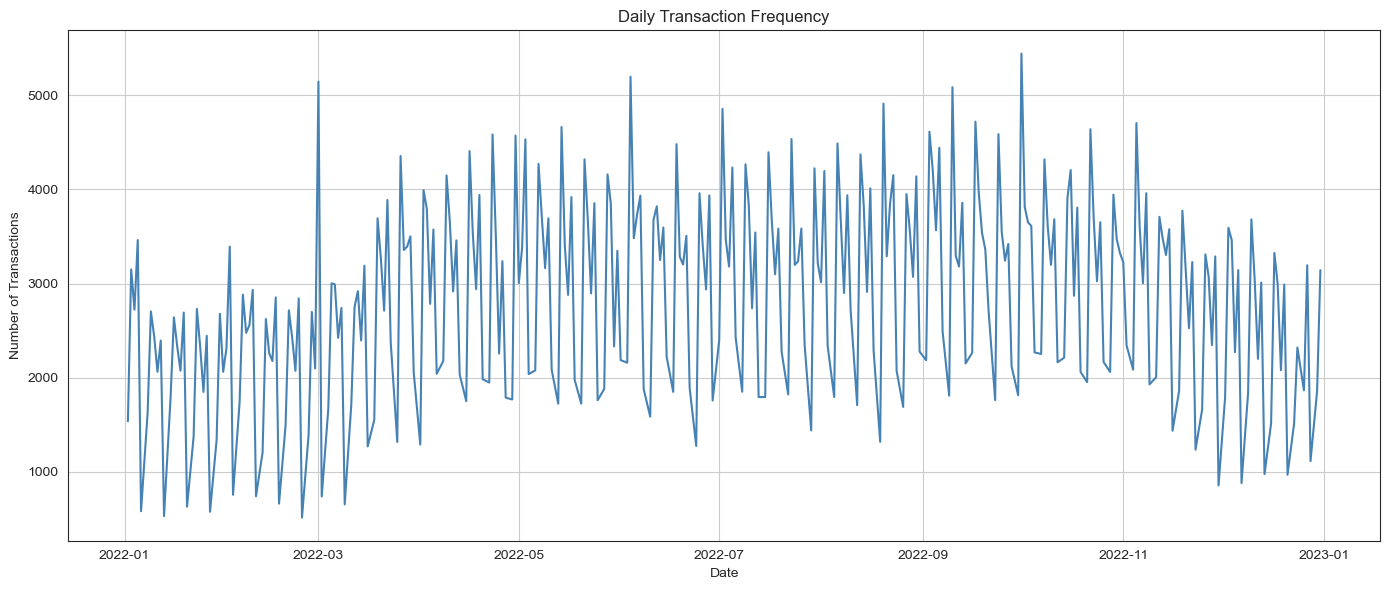

In [254]:
transaction_counts = full_df_exploration.groupby(full_df_exploration['Date'].dt.date).size()

plt.figure(figsize=(14, 6))
transaction_counts.plot(kind='line', color='steelblue')
plt.title('Daily Transaction Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

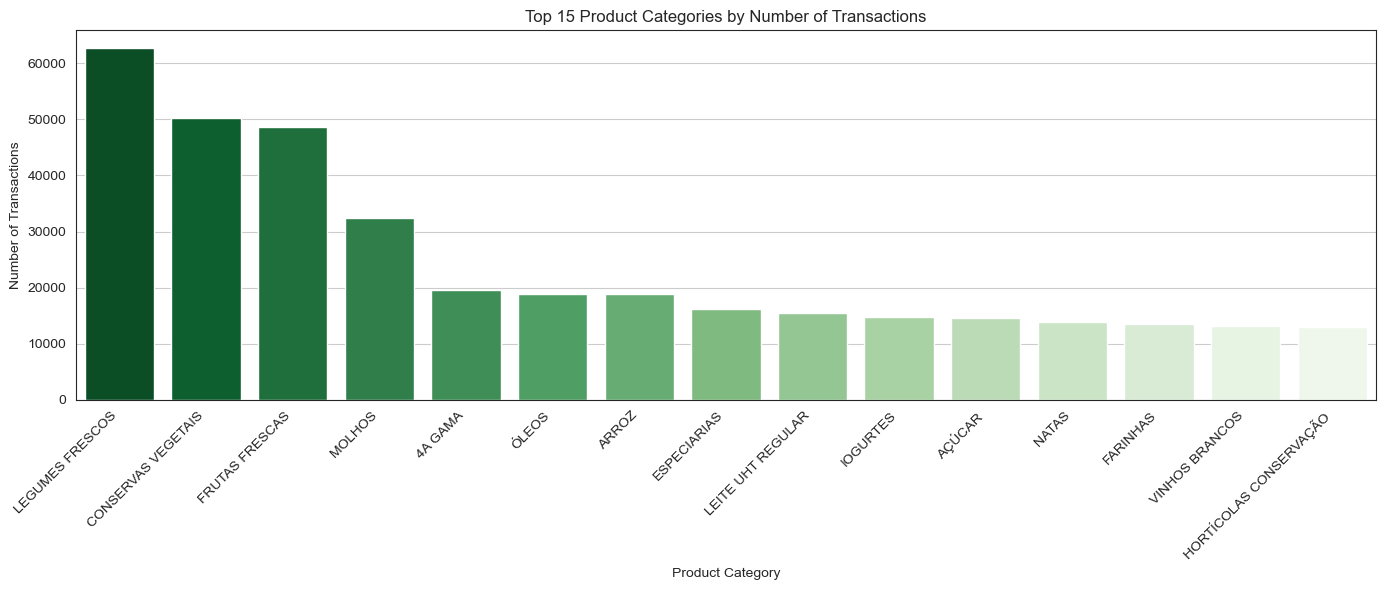

In [255]:
# transactions by product category
category_counts = full_df_exploration["ID Product Category"].value_counts().head(15)

# top categories by transaction
plt.figure(figsize=(14, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="Greens_r")
plt.title("Top 15 Product Categories by Number of Transactions")
plt.xlabel("Product Category")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

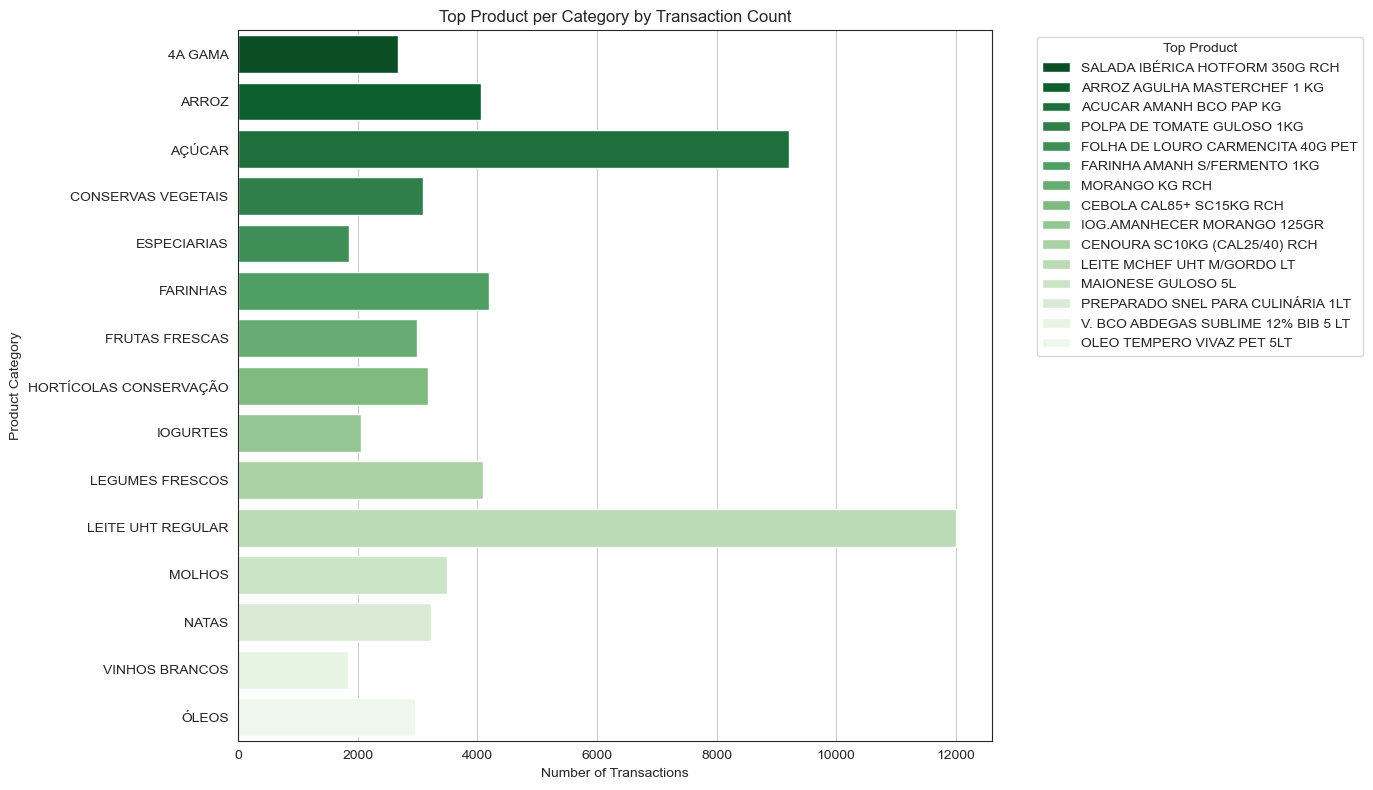

In [256]:
# top categories
top_categories = category_counts.index.tolist()

# top categories dataset
top_category_products = full_df_exploration[full_df_exploration["ID Product Category"].isin(top_categories)]

# summary category 
top_products_per_category = (
    top_category_products.groupby(["ID Product Category", "Product Description"])
    .size()
    .reset_index(name="Transaction Count")
    .sort_values(["ID Product Category", "Transaction Count"], ascending=[True, False])
)

# top product per category
top_per_category = top_products_per_category.groupby("ID Product Category").first().reset_index()

# plot
plt.figure(figsize=(14, 8))
sns.barplot(
    y=top_per_category["ID Product Category"],
    x=top_per_category["Transaction Count"],
    hue=top_per_category["Product Description"],
    dodge=False,
    palette="Greens_r"
)
plt.title("Top Product per Category by Transaction Count")
plt.xlabel("Number of Transactions")
plt.ylabel("Product Category")
plt.legend(title="Top Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

Insights from Product Categories and Product-Level Transaction Analysis

1. Top 15 Product Categories by Number of Transactions <br>
By analyzing the number of transactions per product category, we found that a small group of categories accounts for the majority of sales. These include:

- **Legumes Frescos**
- **Conservas vegetais**
- **Frutas Frescas**
- **Condimentos**
- Among others commonly used in restaurant and catering environments (molhos, oleo, arroz).

This highlights the importance of essential ingredients and staple goods in Recheio’s B2B business. It also confirms that the core of their product demand comes from **basic, high-rotation items** used in daily operations by cafés, restaurants, and institutional kitchens.

---

2. Most Purchased Product per Category <br>
To go one level deeper, we identified the **top-selling product within each of the top 15 categories**. This allows us to pinpoint exactly which SKUs drive the most volume inside each family. 

Some observations include:
    - Even though multiple products exist, one consistently stands out — suggesting it might be the default choice for many clients.

**Strategic Implications:**
- These products could be promoted, bundled, or used as defaults in recommendation engines.
- Understanding product-level dominance helps optimize inventory, pricing, and personalized promotions.


### **Sales by Semester**

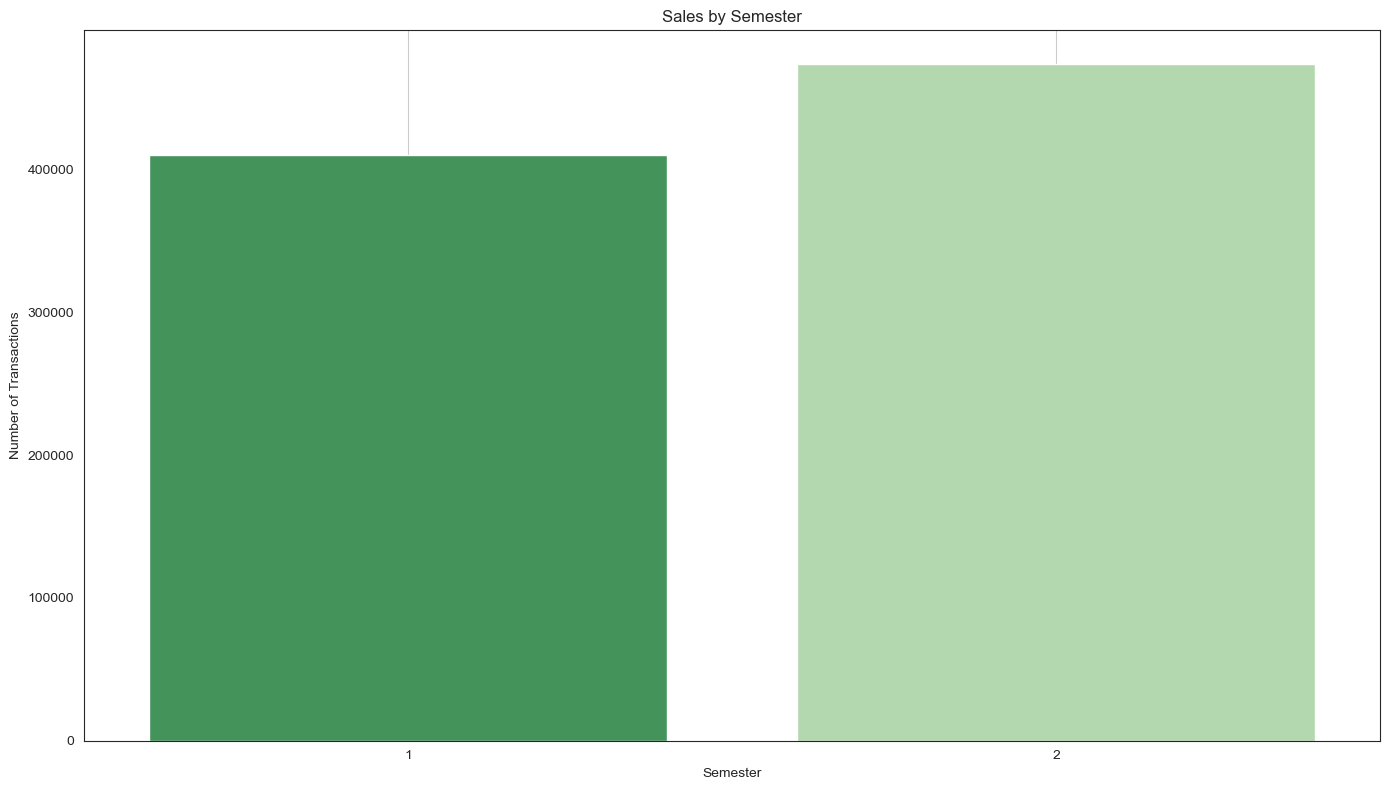

In [257]:
# grouping by 'Semester' and counting the number of transactions (products)
sales_by_semester = full_df_exploration.groupby('Semester').size().reset_index(name="Transaction Count")

# plot
plt.figure(figsize=(14, 8))
sns.barplot(
    y=sales_by_semester["Transaction Count"],
    x=sales_by_semester["Semester"],
    palette="Greens_r"
)
plt.title("Sales by Semester")
plt.xlabel("Semester")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

**Insight: Sales Semester 2 > Semester 1** <br>

From the bar chart, we can observe that the number of transactions (products sold) in Semester 2 is higher than in Semester 1. This suggests that customers tend to purchase more products during the second half of the year.

This could be attributed to various factors such as:

- Seasonal demand: Many products may experience higher demand during the second semester, possibly due to holidays or special events.

- Sales promotions: Companies may offer discounts or promotions in the second semester, driving more transactions.

- Economic factors: Consumers may have higher disposable income or more purchasing power later in the year.

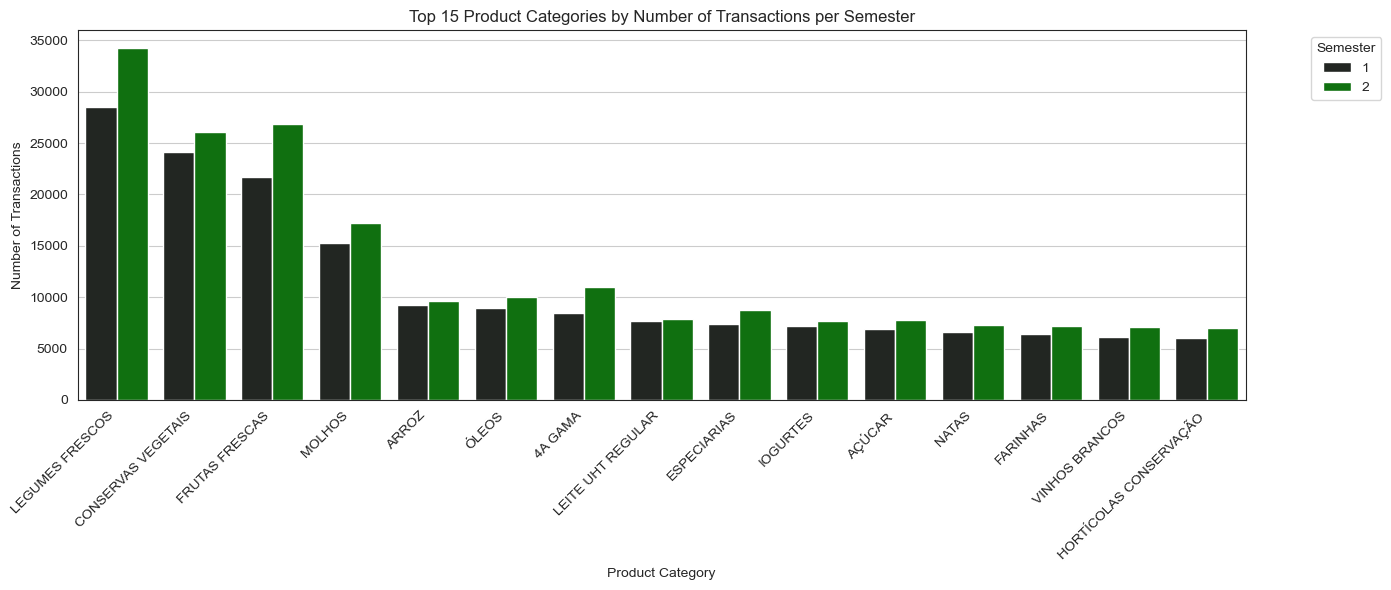

In [258]:
filtered_df = full_df_exploration[full_df_exploration["ID Product Category"].isin(top_categories)]

# grouby category and semester
category_semester_counts = (
    filtered_df.groupby(["Semester", "ID Product Category"])
    .size()
    .reset_index(name="Transaction Count")
)

# sorting to simply visual analysis
category_semester_counts = category_semester_counts.sort_values(by=["Semester", "Transaction Count"], ascending=[True, False])

# palette
num_semesters = category_semester_counts["Semester"].nunique()
custom_green_palette = sns.dark_palette("green", n_colors=num_semesters, reverse=False)

# plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=category_semester_counts,
    x="ID Product Category",
    y="Transaction Count",
    hue="Semester",
    dodge=True,
    palette=custom_green_palette
)

plt.title("Top 15 Product Categories by Number of Transactions per Semester")
plt.xlabel("Product Category")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.legend(title="Semester", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


As observed above, the number of sales is higher is the 2nd Semester, which higher discrepancies for the top products, but becoming less prominent as product category popularity goes down.

### **Sales by Month**

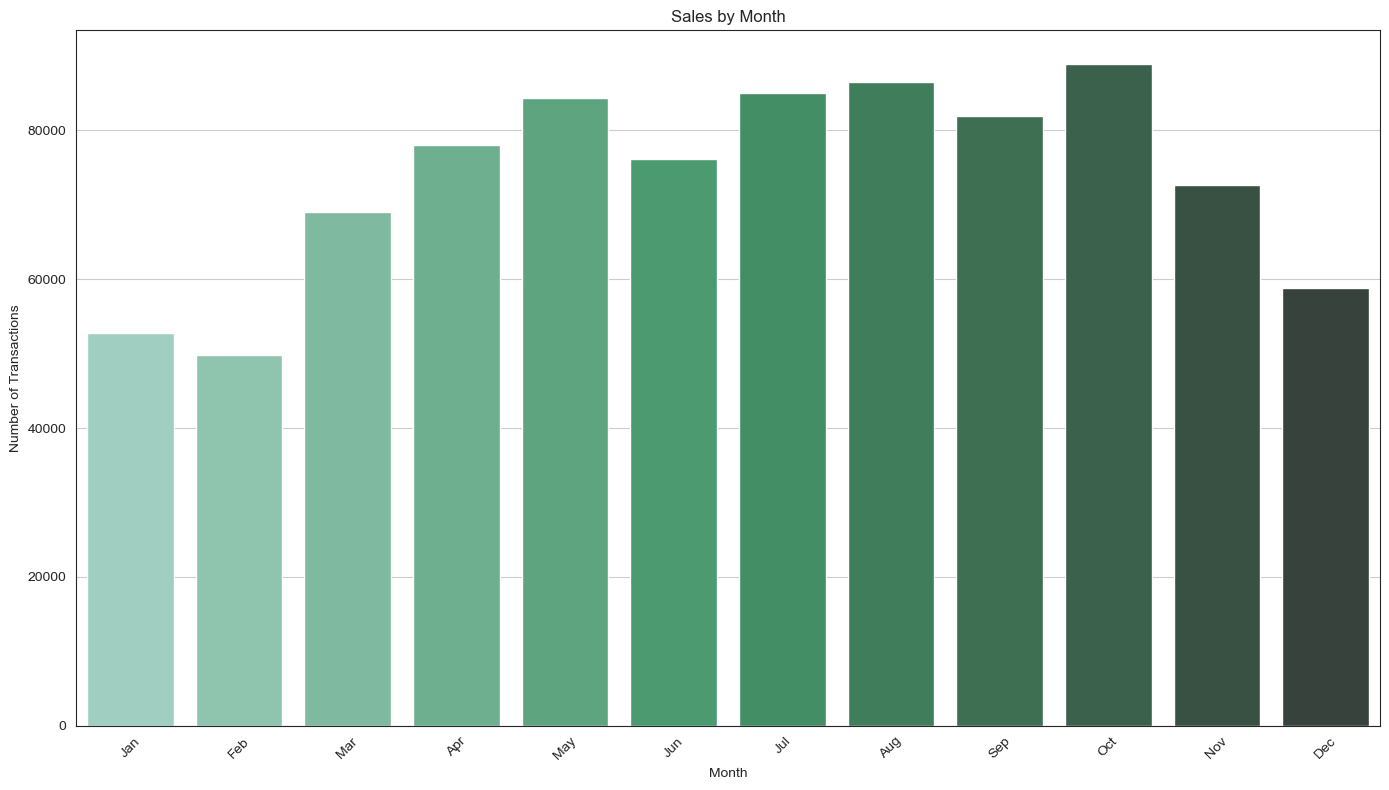

In [259]:
# datetime column
full_df_exploration['Date'] = pd.to_datetime(full_df_exploration['Date'])

# extract month
full_df_exploration['Month'] = full_df_exploration['Date'].dt.month

# group by month and count the number of transactions
sales_by_month = full_df_exploration.groupby('Month').size().reset_index(name="Transaction Count")

# palette
plt.figure(figsize=(14, 8))
sns.barplot(
    x=sales_by_month["Month"],
    y=sales_by_month["Transaction Count"],
    palette="BuGn_d"
)

# plot
plt.title("Sales by Month")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

**Insight: Higher sales in July and August. Lowest Transaction Numbers in January and December** <br>

The graph shows a periodic performance in terms of sales, which are higher in the summer months, particularly July and August, and decline towards the end of the year with January and December having the lowest transactions. This suggests a peak in sales during mid-year, possibly due to:

- Seasonal demand: Mid-year months might coincide with higher consumer spending, especially during summer or major sales events.

- Holiday shopping: December could see fewer transactions due to post-holiday recovery or early holiday shopping in November.

- Consumer behavior: People might spend less at the start of the year (January) due to new year financial planning or holiday spending recovery.

- Promotions or discounts: Certain months may have more promotions or product releases, increasing sales during those times.

These factors, individually or together, could contribute to the sales patterns shown.

### **Sales by Weekday**

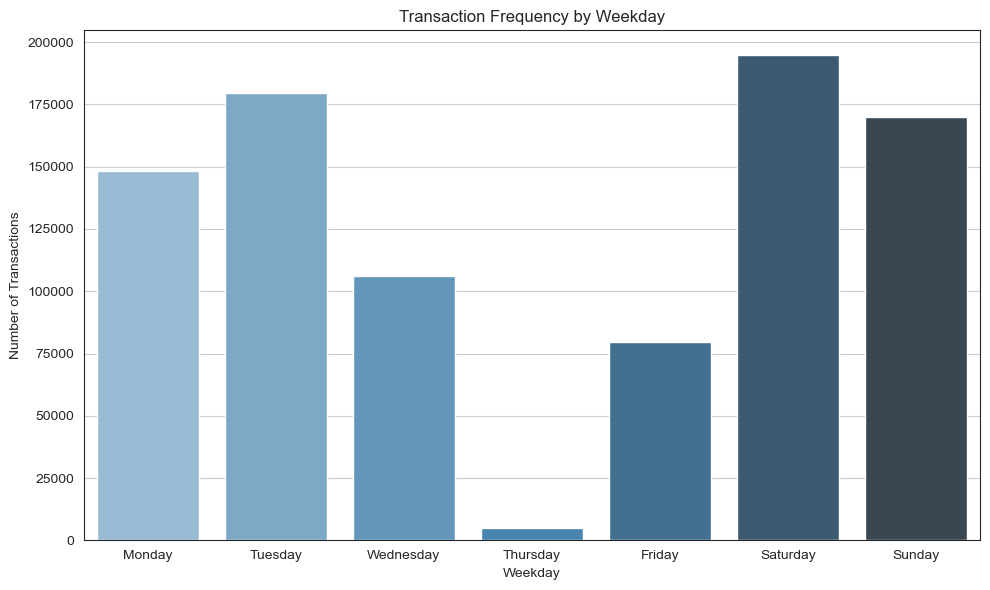

In [260]:
weekday_counts = full_df_exploration.groupby('Week Day').size()
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# creating a auxiliary df
weekday_counts.index = pd.Categorical(weekday_counts.index, categories=weekday_names, ordered=True)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="Blues_d")
plt.title('Transaction Frequency by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Transactions')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [261]:
transaction_per_weekday = weekday_counts.reset_index(name='Number of Transactions')
transaction_per_weekday

,index,Number of Transactions
0,Friday,79748
1,Monday,148356
2,Saturday,194984
3,Sunday,170165
4,Thursday,5001
5,Tuesday,179632
6,Wednesday,106204


**Insight:** More transactions completed on the Weekends or beggining of the week. (Saturday, Sunday and Monday, Tuesday). <br>

The graph shows a periodic performance in terms of sales, which are more prominent at the end and in the beginning of the week, and decline towards the middle with Thursday having the lowest transactions (only 5000), by a very considerable amount. This makes sense as businesses usually have to prepare their weeks ahead and plan accordingly only getting more supplies if necessary.

### **Client Acquisition**

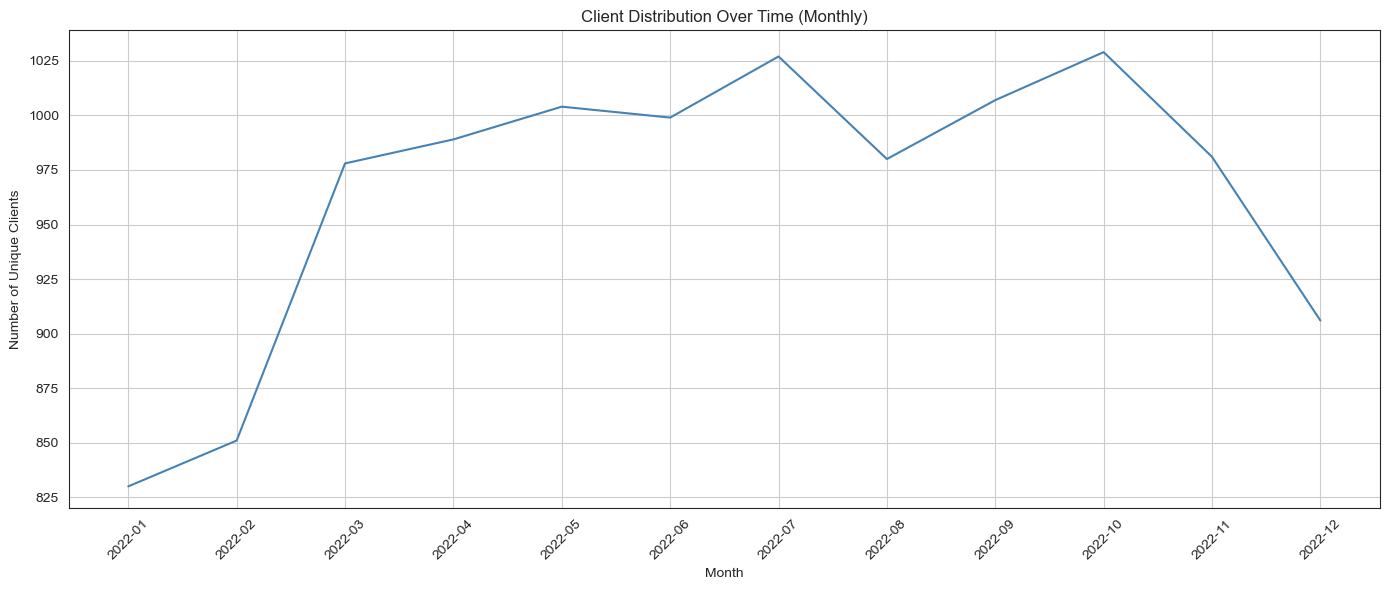

In [262]:
# client acquision graph
monthly_client_counts = full_df_exploration.groupby(full_df_exploration['Date'].dt.to_period('M'))['Client ID'].nunique()

plt.figure(figsize=(14, 6))
sns.lineplot(x=monthly_client_counts.index.astype(str), y=monthly_client_counts.values, color='steelblue')
plt.title('Client Distribution Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Number of Unique Clients')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Insight:** The number of clients increased overtime. <br>

The graph shows a periodic performance in terms of unique clients using Recheio's services. It shows a steady early growth with a significant jump from February to March. It then plateau'd and showed small fluctuations until October. From this point until december there was a decline in over 100 clients.
It also displays a lot of indicators for Seasonality and Business Cycles as there was a rapid client acquisition early in the year, then strong retention/engagement but at the end of the year, as business usually wrap up projects and search for more competitive options, we can see a lot of client churn.

# ``3. Preprocess``

## ``3.1. Preprocess``

``Coherence Checking``


In [263]:
# since we know some products are the same but have different product ID's, let's clean this
duplicates = products_df[products_df.duplicated(subset=["Product Description"], keep=False)]
print(f"There are {len(duplicates)} duplicated products.")
duplicates

There are 20 duplicated products.


,ID Product,Product Description,ID Product Category
329,923162,CREME VEGETAL MCHEF KG,CREMES VEGETAIS
1382,714976,DIP POT MOLHO ALHO HEINZ 100X 25GR,MOLHOS
1416,13545,MISTURA SOLÚVEL MOKAMBO 200G,CAFÉS E MISTURAS
1492,103911,TAB CHOC LEITE TOBLERONE 35G,CHOCOLATE
1676,942002,V DOURO MONTES ERMOS COLHEITA TTO 75CL,VINHOS TINTOS
2466,965058,"FEIJÃO PRETO CISTER BOLSA 3/1,8 KG",CONSERVAS VEGETAIS
2854,957861,"FEIJÃO PRETO CISTER BOLSA 3/1,8 KG",CONSERVAS VEGETAIS
2883,946293,CABO ESFREGONA VILEDA SUPER 1UN,ACESSÓRIOS LIMPEZA GERAL
2980,460163,V.DOURO CALLABRIGA TTO 75CL,VINHOS TINTOS
3359,799703,V DOURO MONTES ERMOS COLHEITA TTO 75CL,VINHOS TINTOS


In [264]:
# removing outdated product_id's (keeping the one with the highest ID Product, assuming higher = newer)
products_df = (
    products_df.sort_values("ID Product")  # 
    .drop_duplicates(subset=["Product Description"], keep='last')
    .reset_index(drop=True)
)

print(f"Unique products after cleaning: {products_df.shape[0]}")
# dropped 20 products with outdated entries in the df

Unique products after cleaning: 4573


`Product Research`

We wanted to better understand some of the products in the dataset, if we had enough information to know what they were and if they made sense, so we will conduct a simple analysis based on `ID Product Category`.

In [265]:
product_categories = products_df['ID Product Category'].unique()
print(f"There are {len(product_categories)} product categories.")

There are 268 product categories.


With the help of a for loop, we iterated throught the most common words in our product categories to find entries that could be grouped together.

In [266]:
all_words = []
for category in product_categories:
    if isinstance(category, str):  
        words = re.findall(r'\b\w+\b', category.lower())  
        all_words.extend(words) 

word_counts = Counter(all_words)
most_common_words = word_counts.most_common()
most_common_words 

[('e', 22),
 ('de', 21),
 ('outros', 10),
 ('peixe', 8),
 ('vegetais', 7),
 ('produtos', 6),
 ('queijos', 6),
 ('para', 6),
 ('papel', 5),
 ('leite', 5),
 ('cervejas', 5),
 ('descartáveis', 5),
 ('especialidades', 5),
 ('vinho', 4),
 ('folha', 4),
 ('sobremesas', 4),
 ('marisco', 4),
 ('prato', 4),
 ('roupa', 4),
 ('pão', 4),
 ('louças', 4),
 ('vinhos', 3),
 ('padaria', 3),
 ('massas', 3),
 ('sumos', 3),
 ('conservas', 3),
 ('guardanapos', 3),
 ('uht', 3),
 ('frutas', 3),
 ('misturas', 3),
 ('preparados', 3),
 ('carne', 3),
 ('vegetal', 3),
 ('fresco', 3),
 ('lixívias', 3),
 ('cremes', 3),
 ('barrar', 3),
 ('cozinha', 3),
 ('cong', 3),
 ('bolos', 3),
 ('sazonais', 3),
 ('pescado', 3),
 ('bacalhau', 3),
 ('ovos', 3),
 ('refrigeradas', 3),
 ('frisantes', 3),
 ('gelados', 3),
 ('limpeza', 2),
 ('espumantes', 2),
 ('estrangeiros', 2),
 ('brancos', 2),
 ('tintos', 2),
 ('sopas', 2),
 ('frescas', 2),
 ('alimentos', 2),
 ('águas', 2),
 ('frescos', 2),
 ('carbonatados', 2),
 ('aperitivos', 2),

In [267]:
products_df[products_df['ID Product Category'] == 'ACESSORIOS TRANSPORTE']

,ID Product,Product Description,ID Product Category
1289,701988,TABULEIRO INOX - COZINHA,ACESSORIOS TRANSPORTE
1647,740528,PALETE EUR E EPAL,ACESSORIOS TRANSPORTE
1648,740530,PALETES ESTRADOS/TARA PERDIDA,ACESSORIOS TRANSPORTE
1649,740532,PALETE 1200X1000,ACESSORIOS TRANSPORTE
3012,911650,CUBA DAVVERO,ACESSORIOS TRANSPORTE
3288,931200,154-CX.POOL PEQ. F&V CPP15,ACESSORIOS TRANSPORTE
3289,931201,106-CX.POOL GRD. F&V CPG10,ACESSORIOS TRANSPORTE
3290,931202,186-CX.POOL GRD. F&V CPG17,ACESSORIOS TRANSPORTE
3324,935622,104-CX.POOL PEQ. F&V CPP10,ACESSORIOS TRANSPORTE
3433,942230,186-04 CX POOL PRETA,ACESSORIOS TRANSPORTE


In [268]:
for category in product_categories:
    if isinstance(category, str) and 'doce' in category.lower():
        print(category)

MEL E DOCES
DOCES E CREMES PARA BARRAR


Changes applied from analysis:

In [269]:
products_df['ID Product Category'] = products_df['ID Product Category'].replace('0', 'MARKETING')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('SAZONAIS', 'SAZONAIS NATAL')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('MEL E DOCES', 'MEL / DOCES / CREMES')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('DOCES E CREMES PARA BARRAR', 'CREMES PARA BARRAR')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('CREMES PARA BARRAR', 'MEL / DOCES / CREMES')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('CREMES PARA BARRAR', 'CREMES PARA BARRAR')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('UTENSILIOS COZINHA', 'COZINHA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PAPEL VEGETAL', 'COZINHA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('TOALHETES', 'TOALHETES / LENÇOS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('LENÇOS DE PAPEL', 'TOALHETES / LENÇOS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('MARISCO', 'MARISCO FRESCO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('GUARDANAPOS FOLHA DUPLA', 'GUARDANAPOS FOLHA DUPLA/TRIPLA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('GUARDANAPOS FOLHA TRIPLA', 'GUARDANAPOS FOLHA DUPLA/TRIPLA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('DESCARTÁVEIS PAPEL', 'DESCARTÁVEIS PAPEL E CARTÃO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('AVES / COELHO', 'AVES / CAÇA / COELHO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('SOBREMESAS REFRIGERADAS', 'SOBREMESAS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('ILHA', 'QUEIJOS REGIONAIS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('QUEIJO PRATINHO', 'QUEIJOS PRATO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('4A GAMA', 'HORTOFRUTICOLAS FRESCOS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PADARIA E PASTELARIA', 'PASTELARIA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PRODUTOS DE PADARIA', 'PADARIA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('OUTROS PÃES E ESPECIALIDADES', 'PADARIA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PÃO MINI', 'PADARIA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('BAGUETE', 'PADARIA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PÃO DE HAMBÚRGUER', 'PADARIA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PÃO TAMANHO INDIVIDUAL', 'PADARIA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('LAGOSTA, SAPATEIRA E OUTROS', 'MARISCO FRESCO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('CAMARÃO', 'MARISCO FRESCO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('BIVALVES', 'MARISCO FRESCO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('TINTO | BRANCO', 'VINHOS TINTOS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('MOZZARELA', 'MOZZARELLA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('ESPECIALIDADES PEIXE', 'PESCADO ESPECIALIDADES')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('OVOS CODERNIZ', 'OVOS GAIOLA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('ESPECIALIDADES DE CARNE', 'AVES / CAÇA / COELHO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('POLPAS DE FRUTA', 'FRUTAS EM CONSERVA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PREPARADOS PEIXE', 'PREPARADOS PEIXE E MARISCO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('SALMÃO FUMADO', 'PREPARADOS PEIXE E MARISCO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PEIXE CONG HIGIENIZADO', 'PEIXE CONG EMBALADO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PEIXE CONG GRANEL', 'PEIXE CONG EMBALADO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PEIXE FRESCO AQUICULTURA', 'PEIXES INTEIROS / CORTADOS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PESCADO SELVAGEM', 'PEIXES INTEIROS / CORTADOS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('SUMOS REFRIGERADOS', 'SUMOS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('MISTURAS DE VEGETAIS', 'VEGETAIS DIVERSOS E MISTURAS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('OUTROS VEGETAIS', 'VEGETAIS DIVERSOS E MISTURAS')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('OUTROS AMBIENTADORES', 'CASA DE BANHO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('LOUÇAS DE PLÁSTICO REUTILIZÁVEIS', 'DESCARTÁVEIS PLÁSTICO')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('PRODUTOS PARA CULINÁRIA', 'PRODUTOS PARA DOÇARIA')
products_df['ID Product Category'] = products_df['ID Product Category'].replace('FARINHEIRAS', 'OUTROS ENCHIDOS') 
products_df['ID Product Category'] = products_df['ID Product Category'].replace('MORTADELA', 'OUTROS ENCHIDOS') 
products_df['ID Product Category'] = products_df['ID Product Category'].replace('LINGUIÇA', 'OUTROS ENCHIDOS') # ones with less than 3 different products
products_df = products_df[products_df['ID Product Category'] != 'OUTROS CONJUNTOS'] # this doens't give us any relevant information
products_df = products_df[products_df['ID Product Category'] != 'ARTIGOS DESCONTO'] # this doens't give us any relevant information
products_df = products_df[products_df['ID Product Category'] != 'MENU'] # ambiguous meaning


In [270]:
product_categories = products_df['ID Product Category'].unique()
print(f"There are {len(product_categories)} product categories.")

There are 221 product categories.


``Locations with NaN`` 

In [271]:
num_missing_locations = len(clients_df[clients_df["Location"].isna()])
print(f"There are {num_missing_locations} entries without location information.")

There are 109 entries without location information.


In [272]:
clients_df[clients_df["Location"].isna()].head()

,Client ID,ZIP Code,ID Client Type,Location
73,210100078,0,NaN,NaN
74,210100079,0,NaN,NaN
76,210100081,4175,NaN,NaN
330,210100335,0,NaN,NaN
331,210100336,0,NaN,NaN


During the data exploration phase, we identified a group of clients whose `Location` field is missing (`NaN` values).
Upon further inspection, we noted that:

- The majority of these clients also have their `Client Type` marked as "NaN".
- There are some `ZIP Code` values that are invalid (e.g., 0, 1) or do not correspond to any known Portuguese postal code formats.
- Some missing `Location` information can possibly be imputed (roughly 70 entries) with some research of portuguese postal codes. 

Given the importance of the `Location` attribute for future segmentation, regional analysis, and potentially in recommendation models, we decided to go with this approach.

- **Only clients without a valid Location will be completely removed from the dataset**.
- This ensures that the dataset remains clean and that all remaining clients have full geographical information available.

Source: https://www.codigo-postal.pt/ <br>

- 4175 - Uncertain (Porto)
- 4536 - MOZELOS, Aveiro
- 4451 - Matosinhos, Porto 
- 4416 - GRIJÓ VNG Grijó, Vila Nova de Gaia, Porto
- 4476 - MAIA Águas Santas, Maia, Porto
- 4466 - LEÇA DO BALIO Leça do Balio, Matosinhos, Porto
- 4751 - Barcelos, Braga
- 4885 - Uncertain (Porto)
- 4711 - BRAGA Maximinos, Braga
- 4811 - GUIMARÃES Urgezes, Guimarães, Braga
- 4784 - AREIAS STS Areias, Santo Tirso, Porto
- 4469 - Uncertain (Porto)

0, 1 and 3 are not valid post codes. <br>
All invalid entries will be dropped. All valid entries will be imputed.


In [273]:
# imputing valid post codes
client_location_mapping = {4175: "PORTO", 4536: "AVEIRO", 4451: "MATOSINHOS", 4416: "VILA NOVA DE GAIA", 4476: "MAIA", 4466: "MATOSINHOS", 4751: "BRAGA", 4885: "PORTO", 4711: "BRAGA", 4811: "GUIMARAES", 4784: "PORTO", 4469: "PORTO"}
clients_df['Location'] = clients_df.apply(
    lambda row: client_location_mapping.get(row['ZIP Code'], row['Location']),
    axis=1
)

In [274]:
# dropping invalid entries
clients_df = clients_df[~clients_df['ZIP Code'].isin([0, 1, 3])]

In [275]:
# checking our clients df now
num_missing_locations = len(clients_df[clients_df["Location"].isna()])
print(f"There are {num_missing_locations} entries without location information.")

There are 0 entries without location information.


``Grouping Client Type``

In [276]:
# show all unique Client ID Types
clients_df["ID Client Type"].unique()

array([nan, 'Hotelaria', 'Coletiva/Instituição/Cantina', 'Catering',
       'Café/Pastelaria', 'Restaurante - Churrasqueira',
       'Restaurante - Cozinha Portuguesa', 'Bar/Discoteca',
       'Padaria/Pastelaria', 'Restaurante - Japonês',
       'Restaurante - Chinês', 'Restaurante - Cervejaria',
       'Restaurante - RodÃ\xadzio', 'Mercearia', 'Retail Outros',
       'Garrafeira', 'Restaurante - Tapas & Petiscos',
       'Restaurante - Steak House', 'Restaurante - Cozinha de Autor',
       'Restaurante - Rodízio', 'Frutaria', 'Restaurante - Brasileiro',
       'Restaurante - Italiano',
       'Restaurante - Outra Cozinha Internacional',
       'Restaurante - Marisqueira', 'Restaurante - Mexicano',
       'Restaurante - Vegetariano'], dtype=object)

Now, we are going to transform and group together some client categories that are similar in characteristics and behaviour. This will enrich our recommender system in the future.

In [277]:
# mapping dictionary
client_type_mapping = {
    "Hotelaria": "Hotelaria",
    "Coletiva/Instituição/Cantina": "Coletiva/Instituições",
    "Café/Pastelaria": "Café/Pastelaria",
    "Padaria/Pastelaria": "Café/Pastelaria",
    "Bar/Discoteca": "Bar/Discoteca",
    "Catering": "Catering",
    "Retail Outros": "Comércio/Retail",
    "Mercearia": "Comércio/Retail",
    "Frutaria": "Comércio/Retail",
    "Garrafeira": "Comércio/Retail",
    "Unknown": "Unknown"
}

# applying mapping
def group_client_type(client_type):
    if isinstance(client_type, str): 
        if client_type.startswith("Restaurante"):
            return "Restaurante"
        else:
            return client_type_mapping.get(client_type, "Other")
    else:
        return "Other"  # fallback 

clients_df["Grouped Client Type"] = clients_df["ID Client Type"].apply(group_client_type)

# output
clients_df["Grouped Client Type"].value_counts()


Other                    5744
Hotelaria                 231
Restaurante               186
Coletiva/Instituições     139
Café/Pastelaria            64
Catering                   34
Bar/Discoteca              15
Comércio/Retail            11
Name: Grouped Client Type, dtype: int64

In [278]:
clients_df.drop(columns = ["ID Client Type"], inplace = True)

In [279]:
clients_df.head()

,Client ID,ZIP Code,Location,Grouped Client Type
0,210100002,4049,PORTO,Other
1,210100003,4000,PORTO,Other
2,210100004,4149,PORTO,Other
3,210100005,4100,PORTO,Hotelaria
4,210100006,4405,VILA NOVA DE GAIA,Other


## ``3.2. Feature Engineering``

In this step, we engineered several new features to improve the quality and intelligence of future recommendations.

**Main objective:**  
Capture how recent, frequent, and regular a client's purchases are, giving the system smarter information about client-product relationships.

---

Features Created:

- **Days Since Last Purchase:**  
  Measures the number of days since a client last bought a specific product.

- **Weeks Since Last Purchase:**  
  Same idea but in weeks, to better detect longer-term buying patterns.

- **Frequency:**  
  Total number of times a client bought the same product across the available period.

- **Adjusted Weight (Days/Weeks):**  
  We applied an **exponential decay function** to model that recent purchases should have higher importance, while older ones should gradually become less relevant.

- **Weighted Sum:**  
  A combined ranking score, merging recency, frequency, and loyalty indicators into a single number that can be used to prioritize product recommendations for each client.


In [280]:
transactions_df_new = transactions_df.copy() # copy

In [281]:
# merge product information into transactions
transactions_df_new = transactions_df_new.merge(products_df, on='ID Product', how='left')

# datetime format
transactions_df_new['Date'] = pd.to_datetime(transactions_df_new['Date'])

# sort values (important for time-based calculations)
transactions_df_new = transactions_df_new.sort_values(by=['Client ID', 'ID Product', 'Date'])

In [282]:
# days since last purchase
transactions_df_new['Days Since Last Purchase'] = transactions_df_new.groupby(['Client ID', 'ID Product'])['Date'].diff().dt.days
transactions_df_new['Days Since Last Purchase'] = transactions_df_new['Days Since Last Purchase'].fillna(0)

# weeks since last purchase
transactions_df_new['Weeks Since Last Purchase'] = transactions_df_new['Days Since Last Purchase'] // 7

# frequency
frequency_features = transactions_df_new.groupby(['Client ID', 'ID Product']).size().reset_index(name='Frequency')
transactions_df_new = transactions_df_new.merge(frequency_features, on=['Client ID', 'ID Product'], how='left')

# exponential decay weights
decay_rate = 0.1
transactions_df_new['Adjusted Weight (Days)'] = np.exp(-decay_rate * transactions_df_new['Days Since Last Purchase'])
transactions_df_new['Adjusted Weight (Weeks)'] = np.exp(-decay_rate * transactions_df_new['Weeks Since Last Purchase'])


In [283]:
# weighted sum considering all previous factors
weights = {
    'Adjusted Weight (Days)': 0.25,
    'Adjusted Weight (Weeks)': 0.25,
    'Weeks Since Last Purchase': 0.25,
    'Frequency': 0.25
}

In [284]:
transactions_df_new['Weighted Sum'] = (
    (transactions_df_new['Adjusted Weight (Days)'] / transactions_df_new['Adjusted Weight (Days)'].max()) * weights['Adjusted Weight (Days)'] +
    (transactions_df_new['Adjusted Weight (Weeks)'] / transactions_df_new['Adjusted Weight (Weeks)'].max()) * weights['Adjusted Weight (Weeks)'] +
    (1 - (transactions_df_new['Weeks Since Last Purchase'] / transactions_df_new['Weeks Since Last Purchase'].max())) * weights['Weeks Since Last Purchase'] +
    (transactions_df_new['Frequency'] / transactions_df_new['Frequency'].max()) * weights['Frequency']
)

transactions_df_new['Weighted Sum'] = transactions_df_new['Weighted Sum'].round(4)


In [285]:
transactions_df_new.head()

,Date,Client ID,ID Product,Product Description,ID Product Category,Days Since Last Purchase,Weeks Since Last Purchase,Frequency,Adjusted Weight (Days),Adjusted Weight (Weeks),Weighted Sum
0,2022-09-03,210100005,276634,AMEIXA VERMELHA CAL 45+ RCH,FRUTAS FRESCAS,0.0,0.0,2,1.000000,1.0,0.7518
1,2022-09-04,210100005,276634,AMEIXA VERMELHA CAL 45+ RCH,FRUTAS FRESCAS,1.0,0.0,2,0.904837,1.0,0.7280
2,2022-01-23,210100005,277472,MELAO VERDE RCH,FRUTAS FRESCAS,0.0,0.0,22,1.000000,1.0,0.7697
3,2022-01-25,210100005,277472,MELAO VERDE RCH,FRUTAS FRESCAS,2.0,0.0,22,0.818731,1.0,0.7244
4,2022-01-30,210100005,277472,MELAO VERDE RCH,FRUTAS FRESCAS,5.0,0.0,22,0.606531,1.0,0.6713


In [286]:
transactions_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884090 entries, 0 to 884089
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       884090 non-null  datetime64[ns]
 1   Client ID                  884090 non-null  int64         
 2   ID Product                 884090 non-null  int64         
 3   Product Description        883090 non-null  object        
 4   ID Product Category        883090 non-null  object        
 5   Days Since Last Purchase   884090 non-null  float64       
 6   Weeks Since Last Purchase  884090 non-null  float64       
 7   Frequency                  884090 non-null  int64         
 8   Adjusted Weight (Days)     884090 non-null  float64       
 9   Adjusted Weight (Weeks)    884090 non-null  float64       
 10  Weighted Sum               884090 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(2

We can see some missing values in `Product Description` and `ID Product Category` after merging transactions data.

`Addressing Incomplete Transactions Data`

In [287]:
missing_records = transactions_df_new[transactions_df_new['Product Description'].isnull() | transactions_df_new['ID Product Category'].isnull()]
print(f"There are {len(missing_records)} records with missing values in 'Product Description' or 'ID Product Category':")
missing_records.head()

There are 1000 records with missing values in 'Product Description' or 'ID Product Category':


,Date,Client ID,ID Product,Product Description,ID Product Category,Days Since Last Purchase,Weeks Since Last Purchase,Frequency,Adjusted Weight (Days),Adjusted Weight (Weeks),Weighted Sum
11216,2022-03-28,210100314,923162,NaN,NaN,0.0,0.0,1,1.000000,1.000000,0.7509
22119,2022-04-01,210100727,910728,NaN,NaN,0.0,0.0,4,1.000000,1.000000,0.7536
22120,2022-05-01,210100727,910728,NaN,NaN,30.0,4.0,4,0.049787,0.670320,0.4140
22121,2022-08-01,210100727,910728,NaN,NaN,92.0,13.0,4,0.000101,0.272532,0.2580
22122,2022-11-05,210100727,910728,NaN,NaN,96.0,13.0,4,0.000068,0.272532,0.2580


In [288]:
# checking what these values are and if they exist
missing_records['ID Product'].value_counts()

923162     690
910728      89
714976      53
103911      46
9999117     33
13545       28
9999902     14
9999107     12
935493      10
597501       8
814295       6
799703       3
946293       3
460163       2
957861       1
936948       1
925538       1
Name: ID Product, dtype: int64

In [289]:
# list of product ids identified
product_ids_to_check = [
    923162, 910728, 714976, 103911, 9999117, 13545, 9999902, 9999107,
    935493, 597501, 814295, 799703, 946293, 460163, 957861, 936948, 925538
]

# check match
matching_products = products_df[products_df['ID Product'].isin(product_ids_to_check)]

if not matching_products.empty:
    print("The following product IDs exist in the products_df:")
    print(matching_products)
else:
    print("None of the product IDs exist in the products_df.")


None of the product IDs exist in the products_df.


Therefore we have no information on what these products are and these records can be dropped as they don't provide any information.

In [290]:
# dropping rows in transactional df
transactions_df_new = transactions_df_new[~transactions_df_new['ID Product'].isin(product_ids_to_check)]

In [291]:
transactions_df_new.shape

(883090, 11)

Our final transactions dataset has `883090` records.

### ⚠️ **Client Type Problem**

In [292]:
full_df = transactions_df_new.copy()
full_df = full_df.merge(clients_df, on='Client ID', how='left')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 883090 entries, 0 to 883089
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       883090 non-null  datetime64[ns]
 1   Client ID                  883090 non-null  int64         
 2   ID Product                 883090 non-null  int64         
 3   Product Description        883090 non-null  object        
 4   ID Product Category        883090 non-null  object        
 5   Days Since Last Purchase   883090 non-null  float64       
 6   Weeks Since Last Purchase  883090 non-null  float64       
 7   Frequency                  883090 non-null  int64         
 8   Adjusted Weight (Days)     883090 non-null  float64       
 9   Adjusted Weight (Weeks)    883090 non-null  float64       
 10  Weighted Sum               883090 non-null  float64       
 11  ZIP Code                   883090 non-null  int64   

In [293]:
grouped_df = full_df.groupby('Client ID').sum()
print(f"There are {len(grouped_df)} unique active customers in the dataset. So these are the ones we will consider.")

There are 1526 unique active customers in the dataset. So these are the ones we will consider.


In [294]:
df = full_df.copy()

# aggregations that describe customer behavior
client_profiles = df.groupby('Client ID').agg(
    total_transactions=('ID Product', 'count'), # amount of purchases
    unique_products=('ID Product', pd.Series.nunique), # number of unique products
    unique_categories=('ID Product Category', pd.Series.nunique), # number of unique categories products were from
    first_purchase=('Date', 'min'), # date of first purchase
    last_purchase=('Date', 'max'), # date of last purchase
    active_days=('Date', pd.Series.nunique), # number of unique days the client made a purchase
    grouped_client_type=('Grouped Client Type', 'first') # client type
)

# frequency of purchases
client_profiles['days_active'] = (client_profiles['last_purchase'] - client_profiles['first_purchase']).dt.days + 1
client_profiles['transactions_per_day'] = client_profiles['total_transactions'] / client_profiles['days_active']

# product category mode
mode_category = df.groupby('Client ID')['ID Product Category'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
client_profiles['most_common_category'] = mode_category

# entropy/variety in purchases
def calc_category_entropy(x):
    counts = x.value_counts(normalize=True)
    return entropy(counts)

category_entropy = df.groupby('Client ID')['ID Product Category'].apply(calc_category_entropy)
client_profiles['category_entropy'] = category_entropy

# structuring
client_profiles.drop(columns=['first_purchase', 'last_purchase'], inplace=True)
client_profiles.reset_index().head()

,Client ID,total_transactions,unique_products,unique_categories,active_days,grouped_client_type,days_active,transactions_per_day,most_common_category,category_entropy
0,210100005,82,41,18,29,Hotelaria,254,0.322835,FRUTAS FRESCAS,2.051907
1,210100012,6,4,3,2,Other,64,0.093750,ACESSORIOS TRANSPORTE,0.867563
2,210100033,1242,152,42,111,Hotelaria,360,3.450000,LEGUMES FRESCOS,2.916216
3,210100051,683,103,37,48,Coletiva/Instituições,361,1.891967,IOGURTES,2.825453
4,210100096,432,113,41,23,Other,336,1.285714,MASSAS,3.451035


In [295]:
# these are the unique client id's we have, indicating unique customers
print(f"There are {len(clients_df)} unique clients.")
print(f"There are {len(client_profiles)} active customers/client profiles.")

There are 6424 unique clients.
There are 1526 active customers/client profiles.


In [296]:
# checking if there are customers in the client df that don't have a purchase in the analysis period
unique_clients_in_clients_df = set(clients_df['Client ID'])
unique_clients_in_transactions_df = set(transactions_df_new['Client ID'])

# store ids
clients_with_no_transactions = unique_clients_in_clients_df - unique_clients_in_transactions_df

print(f"There are {len(clients_with_no_transactions)} clients with no transactions.")
print(f"There are {len(unique_clients_in_transactions_df)} clients with transactions.")

There are 4898 clients with no transactions.
There are 1526 clients with transactions.


In [297]:
# confirming results
client_transactions = transactions_df[transactions_df['Client ID'] == 210100002]
if not client_transactions.empty:
    print(f"Client 210100002 made {len(client_transactions)} purchase(s).")
else:
    print("Client 210100002 did not make any purchases.")

Client 210100002 did not make any purchases.


In [298]:
client_profiles['grouped_client_type'].value_counts()

Other                    1098
Hotelaria                 170
Coletiva/Instituições      95
Restaurante                77
Café/Pastelaria            45
Catering                   24
Bar/Discoteca              10
Comércio/Retail             7
Name: grouped_client_type, dtype: int64

**Insight:** This means we only have 1526 active customers and these are the ones we have to classify according to client type.

### **Clustering Approach (K-means)**

In [299]:
# keep numerical columns
features = client_profiles.drop(columns=['most_common_category', 'grouped_client_type'])

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

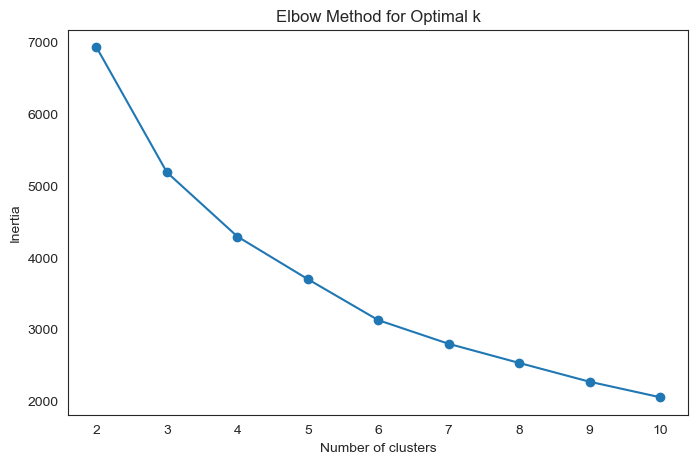

In [300]:
# elbow method for kmeans to find the optimal k for clustering
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [301]:
# 6 seems like an appropriate k
kmeans = KMeans(n_clusters=6, random_state=42)
client_profiles['behavior_cluster'] = kmeans.fit_predict(X_scaled)

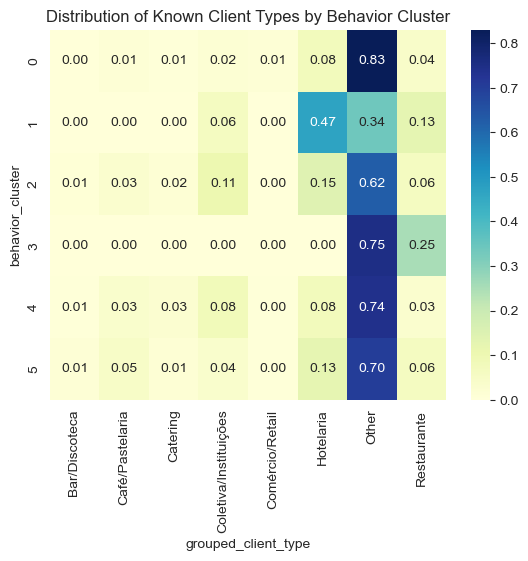

In [302]:
clustered = client_profiles.reset_index()

# assessing how target relates to each cluster
cluster_summary = pd.crosstab(clustered['behavior_cluster'], clustered['grouped_client_type'], normalize='index')
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Distribution of Known Client Types by Behavior Cluster')
plt.show()

In [303]:
# mapping clusters according to defined threshold - because we have really low scores, we defined our threshold kind of low
cluster_threshold = 0.24

# drop 'other'
cluster_known = cluster_summary.drop(columns='Other', errors='ignore')

# top type and value
cluster_mapping = cluster_known.idxmax(axis=1).to_frame(name='dominant_type')
cluster_mapping['dominance'] = cluster_known.max(axis=1)

# apply
confident_clusters = cluster_mapping[cluster_mapping['dominance'] >= cluster_threshold]

In [304]:
cluster_to_type = confident_clusters['dominant_type'].to_dict()

# impute new client type based on clustering
def impute_client_type(row):
    if row['grouped_client_type'] == 'Other':
        cluster = row['behavior_cluster']
        if cluster in cluster_to_type:
            return cluster_to_type[cluster]
    return row['grouped_client_type']

client_profiles['imputed_client_type'] = client_profiles.apply(impute_client_type, axis=1)

In [305]:
# impute values where grouped_client_type is other and imputed type is different than other
imputed_clients = client_profiles.query("`grouped_client_type` == 'Other' and `imputed_client_type` != 'Other'")
print(f"Total imputed clients: {len(imputed_clients)}")

Total imputed clients: 19


In [306]:
# assessing results
comparison = pd.DataFrame({
    'Original': client_profiles['grouped_client_type'].value_counts(),
    'Imputed': client_profiles['imputed_client_type'].value_counts()
}).fillna(0).astype(int)
comparison

,Original,Imputed
Other,1098,1079
Hotelaria,170,186
Coletiva/Instituições,95,95
Restaurante,77,80
Café/Pastelaria,45,45
Catering,24,24
Bar/Discoteca,10,10
Comércio/Retail,7,7


### Train Model to predict other client types

In [307]:
# separate into dfs what we want to predict stil
known = client_profiles[client_profiles['imputed_client_type'] != 'Other']
unknown = client_profiles[client_profiles['imputed_client_type'] == 'Other']

# feature columns and target
feature_cols = ['total_transactions', 'unique_products', 'unique_categories',
                'active_days', 'transactions_per_day', 'category_entropy', 'behavior_cluster']

X_known = known[feature_cols]
y_known = known['imputed_client_type']

X_unknown = unknown[feature_cols]

In [308]:
# scale features
scaler = StandardScaler()
X_known_scaled = scaler.fit_transform(X_known)
X_unknown_scaled = scaler.transform(X_unknown)
X_known_scaled = pd.DataFrame(X_known_scaled, columns=X_known.columns)
X_unknown_scaled = pd.DataFrame(X_unknown_scaled, columns=X_unknown.columns)

`Naive Bayes`

In [309]:
# train/test split
X_train, X_val, y_train, y_val = train_test_split(X_known_scaled, y_known, test_size=0.2, stratify=y_known, random_state=42)

# naive bayes model
nb_model = GaussianNB()

# fit
nb_model.fit(X_train, y_train)

# evaluation
y_pred = nb_model.predict(X_val)

# results
report = classification_report(y_val, y_pred, target_names=y_known.unique(), output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(report_df)


Classification Report:
                       precision    recall  f1-score    support
Hotelaria               0.000000  0.000000  0.000000   2.000000
Coletiva/Instituições   0.173913  0.444444  0.250000   9.000000
Catering                0.000000  0.000000  0.000000   5.000000
Café/Pastelaria         0.241379  0.368421  0.291667  19.000000
Restaurante             0.000000  0.000000  0.000000   1.000000
Bar/Discoteca           0.777778  0.368421  0.500000  38.000000
Comércio/Retail         0.600000  0.187500  0.285714  16.000000
accuracy                0.311111  0.311111  0.311111   0.311111
macro avg               0.256153  0.195541  0.189626  90.000000
weighted avg            0.503411  0.311111  0.348479  90.000000


In [310]:
# cross validation
cv_scores = cross_val_score(nb_model, X_known_scaled, y_known, cv=5, scoring='accuracy')
print(f"Mean cross-validation accuracy: {cv_scores.mean()}")

Mean cross-validation accuracy: 0.23250936329588018


`XGBClassifier`

In [311]:
# train/test split
X_train, X_val, y_train, y_val = train_test_split(X_known_scaled, y_known, test_size=0.2, stratify=y_known, random_state=42)

In [312]:
# encoding categorical label
label_encoder = LabelEncoder()

# fit + transform labels
y_train_encoded = label_encoder.fit_transform(y_train)

# xgb model
model = XGBClassifier(random_state=42)

# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
}

# run grid search to find best parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

# fit grid
grid_search.fit(X_train, y_train_encoded)

# get best paramenters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# fit 
best_model = grid_search.best_estimator_

# evaluation + results
y_pred_encoded = best_model.predict(X_val)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
print(classification_report(y_val, y_pred))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
                       precision    recall  f1-score   support

        Bar/Discoteca       0.00      0.00      0.00         2
      Café/Pastelaria       0.50      0.22      0.31         9
             Catering       0.50      0.20      0.29         5
Coletiva/Instituições       0.21      0.21      0.21        19
      Comércio/Retail       0.00      0.00      0.00         1
            Hotelaria       0.56      0.82      0.67        38
          Restaurante       0.33      0.19      0.24        16

             accuracy                           0.46        90
            macro avg       0.30      0.23      0.24        90
         weighted avg       0.42      0.46      0.42        90



In [313]:
# cross validation
cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='accuracy')
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

Mean cross-validation accuracy: 0.3950


`RandomForestClassifier`

In [314]:
# train/test split
X_train, X_val, y_train, y_val = train_test_split(X_known, y_known, test_size=0.2, stratify=y_known, random_state=42)

# model rf
clf = RandomForestClassifier(n_estimators=200, max_depth=10, max_features='auto', min_samples_leaf=1, min_samples_split=2, random_state=42)
clf.fit(X_train, y_train)

# evaluation
y_pred = clf.predict(X_val)

# results
report = classification_report(y_val, y_pred, target_names=y_known.unique(), output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(report_df)



Classification Report:
                       precision    recall  f1-score    support
Hotelaria               0.000000  0.000000  0.000000   2.000000
Coletiva/Instituições   0.400000  0.222222  0.285714   9.000000
Catering                0.500000  0.200000  0.285714   5.000000
Café/Pastelaria         0.304348  0.368421  0.333333  19.000000
Restaurante             0.000000  0.000000  0.000000   1.000000
Bar/Discoteca           0.603774  0.842105  0.703297  38.000000
Comércio/Retail         0.571429  0.250000  0.347826  16.000000
accuracy                0.511111  0.511111  0.511111   0.511111
macro avg               0.339936  0.268964  0.279412  90.000000
weighted avg            0.488543  0.511111  0.473598  90.000000


In [315]:
'''# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)'''

'# hyperparameter tuning\nparam_grid = {\n    \'n_estimators\': [100, 200, 500],\n    \'max_depth\': [5, 10, 20],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 5],\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\']\n}\ngrid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)\ngrid_search.fit(X_train, y_train)\nprint("Best hyperparameters:", grid_search.best_params_)'

In [316]:
# cross validation
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

Mean cross-validation accuracy: 0.4397


In [317]:
# assessing feature importances to maybe improve model
importances = clf.feature_importances_
features = X_known.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                Feature  Importance
4  transactions_per_day    0.180369
0    total_transactions    0.173799
5      category_entropy    0.167387
3           active_days    0.154199
1       unique_products    0.153286
2     unique_categories    0.139736
6      behavior_cluster    0.031224


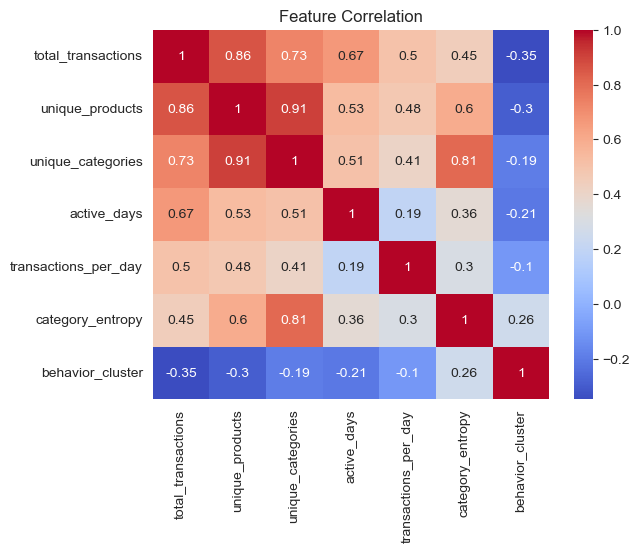

In [318]:
# feature correlation
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

**Output:** Our best model is the RandomForestClassifier. It's accuracy is only of 0.47 but we will go with this approach for now.

- **Precision:** measures how many of the clients predicted to be a certain type (e.g., "Hotelaria") are actually that type. It answers: "Of all the clients that the model said belong to this category, how many actually belong to it?"
- **Recall:** measures how many of the actual clients that belong to a certain type (e.g., "Hotelaria") were correctly identified by the model. It answers: "Of all the actual clients that belong to this category, how many did the model successfully identify?"
- **F1-Score:** is the harmonic mean of Precision and Recall. It balances the two and gives a better measure of the model’s performance when there is an imbalance between Precision and Recall.
- **Support:** indicates the number of actual occurrences of the class in the dataset. It shows how many instances there are for each class.
- **Accuracy:** is the overall percentage of correct predictions across all classes. It’s the ratio of correct predictions to the total number of predictions.
- **Weighted Average:** calculates the average Precision, Recall, and F1-Score across all classes, but it takes into account the number of instances in each class (i.e., it gives more weight to the classes with more samples).

`Predictions`

In [319]:
# predictions on "other" clients
unknown_predictions = clf.predict(X_unknown)  
unknown_probs = clf.predict_proba(X_unknown)  # probabilities to assess confidence
unknown['Predicted Client Type'] = unknown_predictions
unknown['Prediction Confidence'] = unknown_probs.max(axis=1)

prediction_df = unknown[['Predicted Client Type', 'Prediction Confidence']]
prediction_df.head(10)

,Predicted Client Type,Prediction Confidence
Client ID,,
210100012,Hotelaria,0.719443
210100096,Coletiva/Instituições,0.510861
210100160,Hotelaria,0.477774
210100213,Hotelaria,0.402180
210100239,Hotelaria,0.599374
210100254,Coletiva/Instituições,0.338680
210100349,Hotelaria,0.613930
210100369,Hotelaria,0.369468
210100374,Restaurante,0.329502


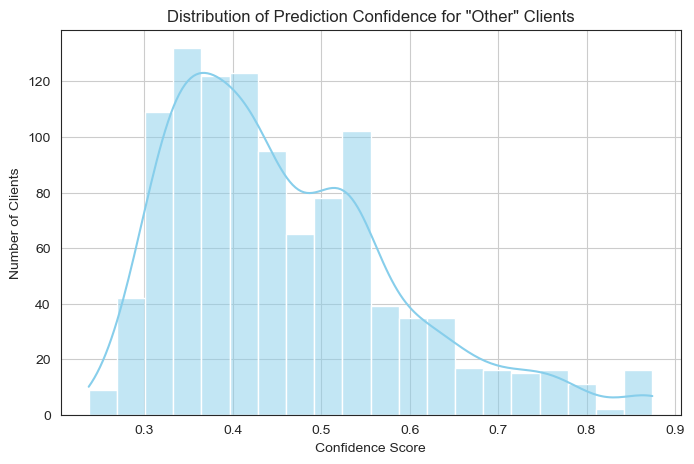

In [320]:
# prediction confidence plot
plt.figure(figsize=(8, 5))
sns.histplot(unknown['Prediction Confidence'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Prediction Confidence for "Other" Clients')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Clients')
plt.grid(True)
plt.show()

In [321]:
# assessing how confidente we are
high_conf = unknown[unknown['Prediction Confidence'] >= 0.5]
low_conf = unknown[unknown['Prediction Confidence'] < 0.5]
print(f"High-confidence predictions: {len(high_conf)}")
print(f"Low-confidence predictions: {len(low_conf)}")

High-confidence predictions: 365
Low-confidence predictions: 714


**Insight:** Our results tell us that for at least 30% of our records we can predict the client type with more than 50% accuracy, which seems reasonable.

In [322]:
# merging predictions back into full dataset
client_profiles.loc[client_profiles['imputed_client_type'] == 'Other', 'Final Client Type'] = unknown['Predicted Client Type']
client_profiles['Final Client Type'] = client_profiles['Final Client Type'].fillna(client_profiles['imputed_client_type'])

In [323]:
# assessing changes made
comparison = pd.DataFrame({
    'Imputed': client_profiles['imputed_client_type'].value_counts(),
    'Predicted': client_profiles['Final Client Type'].value_counts()
}).fillna(0).astype(int)
comparison.sort_values(by='Imputed', ascending=False)

,Imputed,Predicted
Other,1079,0
Hotelaria,186,861
Coletiva/Instituições,95,307
Restaurante,80,181
Café/Pastelaria,45,90
Catering,24,39
Bar/Discoteca,10,10
Comércio/Retail,7,38


`Updating final_df`

In [324]:
client_profiles_reset = client_profiles.reset_index().rename(columns={'index': 'Client ID'})
final_df = full_df.merge(client_profiles_reset[['Client ID', 'Final Client Type']], on='Client ID', how='left')

# ``4. Recommendation System``

In [325]:
def get_actual_purchases(transactions_df, client_id, test_start_date):
    """
    Get the actual products purchased by a client after a given start date.

    Parameters:
    - transactions_df (DataFrame): The full transactions dataset.
    - client_id (str or int): The client ID to filter.
    - test_start_date (str or datetime): The start date for the test period (e.g., "2023-10-01").

    Returns:
    - List of unique product descriptions the client purchased in the test period.
    """
    # datetime format
    transactions_df["Date"] = pd.to_datetime(transactions_df["Date"])

    # filter transactions for the given client and test period
    client_transactions = transactions_df[
        (transactions_df["Client ID"] == client_id) &
        (transactions_df["Date"] >= pd.to_datetime(test_start_date))
    ]

    # extract the products that the client has purchased
    purchased_products = client_transactions["Product Description"].unique().tolist()

    return purchased_products

def calculate_precision_at_k(recommended_items, actual_purchases, k=5):
    """
    Calculate Precision at k.
    
    Parameters:
    recommended_items (list): List of top k recommended items.
    actual_purchases (list): List of actual items that the user interacted with or purchased.
    k (int): The number of top recommendations to consider.
    
    Returns:
    float: Precision at k.
    """
    recommended_at_k = recommended_items[:k]
    
    relevant_items = set(recommended_at_k) & set(actual_purchases)
    precision_at_k = len(relevant_items) / k
    
    return precision_at_k

def calculate_recall_at_k(recommended_items, actual_purchases, k=5):
    """
    Calculate Recall at k.
    
    Parameters:
    recommended_items (list): List of top k recommended items.
    actual_purchases (list): List of actual items that the user interacted with or purchased.
    k (int): The number of top recommendations to consider.
    
    Returns:
    float: Recall at k.
    """
    recommended_at_k = recommended_items[:k]
    
    relevant_items = set(recommended_at_k) & set(actual_purchases)
    
    recall_at_k = len(relevant_items) / len(actual_purchases) if len(actual_purchases) > 0 else 0.0
    
    return recall_at_k

In [326]:
# clients df
new_clients_df = final_df[['Client ID', 'ZIP Code', 'Location', 'Final Client Type']].drop_duplicates().reset_index(drop=True)
print(f"The dataset has {len(new_clients_df)} clients.")
new_clients_df.head(10)

The dataset has 1526 clients.


,Client ID,ZIP Code,Location,Final Client Type
0,210100005,4100,PORTO,Hotelaria
1,210100012,4050,PORTO,Hotelaria
2,210100033,4300,PORTO,Hotelaria
3,210100051,4465,SÃO MAMEDE DE INFESTA,Coletiva/Instituições
4,210100096,4100,PORTO,Coletiva/Instituições
5,210100160,4100,PORTO,Hotelaria
6,210100167,4200,PORTO,Coletiva/Instituições
7,210100182,4050,PORTO,Catering
8,210100213,4570,RATES,Hotelaria
9,210100239,4515,MELRES,Hotelaria


In [327]:
# products df
new_products_df = final_df[['ID Product', 'Product Description', 'ID Product Category']].drop_duplicates().reset_index(drop=True)
print(f"The dataset has {len(new_products_df)} products.")
new_products_df.head(10)

The dataset has 4566 products.


,ID Product,Product Description,ID Product Category
0,276634,AMEIXA VERMELHA CAL 45+ RCH,FRUTAS FRESCAS
1,277472,MELAO VERDE RCH,FRUTAS FRESCAS
2,277630,CURGETE RCH,LEGUMES FRESCOS
3,277674,COGUMELO BRANCO MÉDIO RCH,LEGUMES FRESCOS
4,277680,BERINGELA RCH,LEGUMES FRESCOS
5,277915,PIMENTO VERMELHO RCH,LEGUMES FRESCOS
6,277917,TOMATE BB 67/82 1CAM RCH,LEGUMES FRESCOS
7,277918,PIMENTO VERDE RCH,LEGUMES FRESCOS
8,278129,PEPINO RCH,LEGUMES FRESCOS
9,280064,AMEIXA AMARELA CAL 50+ RCH,FRUTAS FRESCAS


In [328]:
# transactions df
new_transactions_df = final_df[['Date', 'Client ID', 'Final Client Type', 'Location',
        'ID Product', 'Product Description',
       'ID Product Category', 'Days Since Last Purchase',
       'Weeks Since Last Purchase', 'Frequency', 'Adjusted Weight (Days)',
       'Adjusted Weight (Weeks)', 'Weighted Sum']].drop_duplicates().reset_index(drop=True)
print(f"The dataset has {len(new_transactions_df)} transactions.")
new_transactions_df.head()

The dataset has 883090 transactions.


,Date,Client ID,Final Client Type,Location,ID Product,Product Description,ID Product Category,Days Since Last Purchase,Weeks Since Last Purchase,Frequency,Adjusted Weight (Days),Adjusted Weight (Weeks),Weighted Sum
0,2022-09-03,210100005,Hotelaria,PORTO,276634,AMEIXA VERMELHA CAL 45+ RCH,FRUTAS FRESCAS,0.0,0.0,2,1.000000,1.0,0.7518
1,2022-09-04,210100005,Hotelaria,PORTO,276634,AMEIXA VERMELHA CAL 45+ RCH,FRUTAS FRESCAS,1.0,0.0,2,0.904837,1.0,0.7280
2,2022-01-23,210100005,Hotelaria,PORTO,277472,MELAO VERDE RCH,FRUTAS FRESCAS,0.0,0.0,22,1.000000,1.0,0.7697
3,2022-01-25,210100005,Hotelaria,PORTO,277472,MELAO VERDE RCH,FRUTAS FRESCAS,2.0,0.0,22,0.818731,1.0,0.7244
4,2022-01-30,210100005,Hotelaria,PORTO,277472,MELAO VERDE RCH,FRUTAS FRESCAS,5.0,0.0,22,0.606531,1.0,0.6713


**Setting up Strategy for later Evaluation**

In [329]:
# test start date - last 2 months
test_start_date = pd.to_datetime("2022-11-01")

# split into train and test sets
train_df = new_transactions_df[new_transactions_df["Date"] < test_start_date].copy()
test_df = new_transactions_df[new_transactions_df["Date"] >= test_start_date].copy()

print(f"✅ Train set: {len(train_df)} transactions")
print(f"✅ Test set: {len(test_df)} transactions")
print(f"🕒 Test period starts from: {test_start_date.date()}")

✅ Train set: 751705 transactions
✅ Test set: 131385 transactions
🕒 Test period starts from: 2022-11-01


In [386]:
evaluation_df = pd.DataFrame()

In [8127]:
# setting a specific client id to compare between approaches
set_client_id = final_df['Client ID'].sample(1).iloc[0]
previous_client_transactions = train_df[train_df['Client ID'] == set_client_id]
print(f"Test client ID is: {set_client_id}")
print(f"Transactions made before 2022-11-01: {len(previous_client_transactions)}")

Test client ID is: 210105353
Transactions made before 2022-11-01: 3950


## **`4.1. Simple Category-Based Recommendation`**

Simple Category-Based Recommendation System

This function implements a straightforward collaborative filtering approach based on client type similarity.

How it works:

1. **Identify Client Category**  
   The system starts by determining the business category of the target client (e.g., restaurant, hotel, grocery store), based on previously reclassified client types.

2. **Filter Similar Clients**  
   It selects all other clients belonging to the same category, excluding the target client, to act as a peer group.

3. **Aggregate Product Popularity**  
   The system then compiles all transactions from these similar clients and identifies the most commonly purchased products.

4. **Exclude Previously Purchased Items**  
   To avoid recommending redundant items, it filters out any products that the client has already purchased.

5. **Output the Top Recommendations**  
   The final output is a list of the most popular products among similar clients that the current client has not yet bought.


In [8128]:
def simple_category_based_recommender(transactions_df, clients_df, client_id, top_n=10):
    # get client type
    client_category = clients_df.loc[clients_df["Client ID"] == client_id, "Final Client Type"]
    if client_category.empty:
        return f"Client ID {client_id} not found.", None
    client_category = client_category.values[0]
    
    # see what products client has bought before
    client_products = set(transactions_df[transactions_df["Client ID"] == client_id]["Product Description"].unique())
    
    # see what products other customers in the same client type have boguht
    similar_clients = clients_df[
        (clients_df["Final Client Type"] == client_category) &
        (clients_df["Client ID"] != client_id)
    ]
    
    # transactions from similar clients
    similar_transactions = transactions_df[transactions_df["Client ID"].isin(similar_clients["Client ID"])]
    
    # popular products in the similar transactions
    popular_products = similar_transactions["Product Description"].value_counts()
    
    # calculating similarity - Jaccard between client and similar group
    top_similar_products = set(popular_products.head(50).index)
    intersection = len(client_products & top_similar_products)
    union = len(client_products | top_similar_products)
    similarity_index = intersection / union if union != 0 else 0
    
    # recommendations (not including already purchased products)
    recommended_products = (
        popular_products.drop(labels=client_products, errors='ignore')
        .head(top_n)
        .index
        .tolist()
    )
    
    return recommended_products, round(similarity_index, 2)

**Jaccard Similarity Coefficient:** is a statistic used to measure the similarity between two sets. Simply, it tells you what portion of items are shared between two sets compared to the total unique items they have.

In [8129]:
# getting a random client id to test our strategies
random_client_id = final_df['Client ID'].sample(1).iloc[0]

# client description
client_info = new_clients_df[new_clients_df['Client ID'] == random_client_id].iloc[0]
zip_code = client_info['ZIP Code']
location = client_info['Location']
client_type = client_info['Final Client Type']
print(f"🧾 Client Profile - ID: {random_client_id}")
print(f"📍 Location: {location} ({zip_code})")
print(f"👤 Final Client Type: {client_type}")
print("\nTop 10 Product Recommendations:")

# get items
recommended_items, similarity = simple_category_based_recommender(train_df, new_clients_df, random_client_id, top_n=10)
for idx, item in enumerate(recommended_items, 1):
    print(f"{idx}. {item}")
print(f"\nSimilarity Index: {similarity * 100:.1f}%")

🧾 Client Profile - ID: 210103973
📍 Location: PORTO (4885)
👤 Final Client Type: Hotelaria

Top 10 Product Recommendations:
1. OVO PASTEURIZADO TETRA BRIK 1 Lt
2. COGUMELO BRANCO MÉDIO RCH
3. ARROZ AGULHA MASTERCHEF 1 KG
4. PEPINO RCH
5. QJ FLAMENGO VILLAS FAT 1KG
6. FIAMBRE PA MCHEF FATIADO 750GR
7. MANTEIGA MCHEF C/SAL KG
8. RUCÚLA SELVAGEM  HOTFORM 400G RCH
9. 186-04 CX POOL PRETA
10. LARANJA CAL7 (67/76) RCH

Similarity Index: 8.0%


**Similarity Index:** The similarity index represents how closely this client's purchasing behavior aligns with others in the same client type — based on shared product preferences.

**TEST CLIENT**

In [8130]:
# client description
client_info = new_clients_df[new_clients_df['Client ID'] == set_client_id].iloc[0]
zip_code = client_info['ZIP Code']
location = client_info['Location']
client_type = client_info['Final Client Type']
print(f"🧾 Client Profile - ID: {set_client_id}")
print(f"📍 Location: {location} ({zip_code})")
print(f"👤 Final Client Type: {client_type}")
print("\nTop 10 Product Recommendations:")

# get items
recommended_items_simple, similarity = simple_category_based_recommender(train_df, new_clients_df, set_client_id, top_n=10)
for idx, item in enumerate(recommended_items_simple, 1):
    print(f"{idx}. {item}")
print(f"\nSimilarity Index: {similarity * 100:.1f}%")

🧾 Client Profile - ID: 210105353
📍 Location: SÃO JACINTO (3800)
👤 Final Client Type: Hotelaria

Top 10 Product Recommendations:
1. LEITE MCHEF UHT M/GORDO LT
2. OVO PASTEURIZADO TETRA BRIK 1 Lt
3. QJ FLAMENGO VILLAS FAT 1KG
4. FIAMBRE PA MCHEF FATIADO 750GR
5. MANTEIGA MCHEF C/SAL KG
6. CURGETE RCH
7. FARINHA AMANH S/FERMENTO 1KG
8. ATUM MARESIA ÓLEO BOLSA 1KG
9. RUCÚLA SELVAGEM  HOTFORM 400G RCH
10. 186-04 CX POOL PRETA

Similarity Index: 10.0%


## **`4.2. Advanced Hybrid Recommendation`**

 Advanced Hybrid Recommendation System

This advanced recommendation system combines:
- **Content-Based Filtering**: Prioritizes products from categories the client tends to buy.
- **Collaborative Filtering**: Recommends products popular among similar clients (same business type).
- **Behavioral Signals**: Uses recency and frequency of purchases via the precomputed `Weighted Sum`.

Scoring Breakdown
- `0.4` — Recency/Frequency (Weighted Sum)
- `0.3` — Popularity among similar clients (Frequency)
- `0.3` — Category similarity (based on the client’s past preferences)

The final recommendation list excludes products the client already purchased.


In [8131]:
def advanced_hybrid_recommender(transactions_df, clients_df, client_id, top_n=10):
    # client verification
    if client_id not in clients_df["Client ID"].values:
        return f"Client ID {client_id} not found."

    # client info
    client_info = clients_df[clients_df["Client ID"] == client_id].iloc[0]
    client_type = client_info["Final Client Type"]

    # already purchased items by client
    client_history = transactions_df[transactions_df["Client ID"] == client_id]
    client_products = client_history["Product Description"].unique()
    favorite_categories = (
        client_history["ID Product Category"].value_counts(normalize=True).to_dict()
    )

    # candidate products pool (not including those client already purchased)
    similar_clients = clients_df[
        (clients_df["Final Client Type"] == client_type) & 
        (clients_df["Client ID"] != client_id)
    ]
    similar_transactions = transactions_df[
        transactions_df["Client ID"].isin(similar_clients["Client ID"])
    ]

    candidate_products = similar_transactions[
        ~similar_transactions["Product Description"].isin(client_products)
    ]

    # aggregation
    product_stats = candidate_products.groupby("Product Description").agg({
        "ID Product Category": lambda x: x.mode()[0],
        "Weighted Sum": "mean",
        "Frequency": "sum"
    }).reset_index()

    # category similarity score
    def category_score(cat):
        return favorite_categories.get(cat, 0)  # if the client doesn't favor it, assign 0

    product_stats["Category Score"] = product_stats["ID Product Category"].apply(category_score)

    # normalization and scoring
    for col in ["Weighted Sum", "Frequency", "Category Score"]:
        max_val = product_stats[col].max()
        if max_val > 0:
            product_stats[col] = product_stats[col] / max_val
        else:
            product_stats[col] = 0

    # final score
    product_stats["Hybrid Score"] = (
        0.4 * product_stats["Weighted Sum"] +
        0.3 * product_stats["Frequency"] +
        0.3 * product_stats["Category Score"]
    )

    product_stats = product_stats.sort_values(by="Hybrid Score", ascending=False)

    # Return just the product descriptions as a list
    return product_stats["Product Description"].head(top_n).tolist()


In [8132]:
# getting a random client id to test our strategies
random_client_id = final_df['Client ID'].sample(1).iloc[0]

# client description
client_info = new_clients_df[new_clients_df['Client ID'] == random_client_id].iloc[0]
zip_code = client_info['ZIP Code']
location = client_info['Location']
client_type = client_info['Final Client Type']
print(f"🧾 Client Profile - ID: {random_client_id}")
print(f"📍 Location: {location} ({zip_code})")
print(f"👤 Final Client Type: {client_type}")
print("\nTop 10 Product Recommendations:")


advanced_hybrid_recommender(train_df, new_clients_df, random_client_id)


🧾 Client Profile - ID: 210104226
📍 Location: VILA NOVA DE GAIA (4400)
👤 Final Client Type: Coletiva/Instituições

Top 10 Product Recommendations:


['106-CX.POOL GRD. F&V CPG10',
 'PREPARADO SNEL PARA CULINÁRIA 1LT',
 'TABULEIRO INOX - COZINHA',
 'FEIJAO MANTEIGA GULOSO BOLSA 3,2KG',
 'NATA UHT BATER 35% MG MCHEF 1LT',
 'NATA BATER RENY PICOT 1L 35%GO',
 'POLPA TOMATE MCHEF 1LT',
 'NATAS VAQUEIRO CR.&CR.31%1L FS',
 'NATAS GRESSO PASTEURIZ.2,5LT',
 'FEIJAO ENCARNADO MEPS  LATA 2,5KG']

 Understanding the Output: Advanced Hybrid Recommendations

This table shows the **top recommended products** for a selected client, ranked by a **Hybrid Score (0–1)**. The score reflects product relevance based on:

-  **Recency & Frequency** of purchases by similar clients (40%)
-  **Popularity** among clients of the same business type (30%)
-  **Category Match** with the client's historical purchases (30%)

Why These Products?

Recommended items are **not yet purchased** by the client, but:
- Belong to categories they usually buy,
- Are popular among similar businesses,
- Or have been bought recently and frequently by their peers.

> Higher scores indicate greater likelihood of relevance to the client right now.


**TEST CLIENT**

In [8133]:
# client description
client_info = new_clients_df[new_clients_df['Client ID'] == set_client_id].iloc[0]
zip_code = client_info['ZIP Code']
location = client_info['Location']
client_type = client_info['Final Client Type']
print(f"🧾 Client Profile - ID: {set_client_id}")
print(f"📍 Location: {location} ({zip_code})")
print(f"👤 Final Client Type: {client_type}")
print("\nTop 10 Product Recommendations:")


recommended_items_hybrid = advanced_hybrid_recommender(train_df, new_clients_df, set_client_id)
recommended_items_hybrid

🧾 Client Profile - ID: 210105353
📍 Location: SÃO JACINTO (3800)
👤 Final Client Type: Hotelaria

Top 10 Product Recommendations:


['TOMATE RAMA RCH',
 'CURGETE RCH',
 'LARANJA CAL7 (67/76) RCH',
 'TOMATE CHERRY KG RCH',
 'AGRIÃO RCH',
 'COUVE PAK CHOI RCH',
 'TOMATE CHERRY AMARELO 250GR RCH',
 'GRELOS DE NABO PLT',
 'PIMENTA ROSA EMB 50G RCH',
 'PEPINO CX 2KG PLT']

## **`4.3. Two Stage Recommendation`**

Two-Stage Recommendation System for Recheio

This notebook implements a two-moment recommendation system for Recheio, split into:

---

1. Before Shopping Phase

This logic runs before the customer begins shopping and adapts based on their recent activity:

- If the customer is new or has not shopped in the last 2 months:
  - Identify other clients from the same business category (e.g., cafés, restaurants).
  - Retrieve the most purchased products from these clients in the last 2 months.
  - Recommend the top products, with the number of items set to max(15, average basket size).

- If the customer has shopped recently:
  - Build a smart basket using their most frequent purchases from the last 2 months.
  - Look at similar clients’ baskets from the same category.
  - Compute Jaccard similarity to find the 20 most similar baskets.
  - Extract the most frequently co-purchased products that are not in the client's basket.
  - Combine both sets of products and shuffle them to form the final list of suggestions.

---

2. After Shopping Phase

This runs after the customer finishes selecting products and proceeds to checkout:

- Compute each product’s purchase ratio for that client (e.g., bought in 5 of 10 visits = 0.5).
- Recommend products with a ratio above 0.2 that are not already in the cart and were not recommended earlier.
- Identify 20 most similar baskets from other clients (using Jaccard similarity) and extract commonly bought products that:
  - Are not yet in the cart
  - Were not recommended before

Ensure:
- Between 10 and 13 total recommendations
- At least 3 of them come from purchases made by similar clients


In [8134]:
def get_product_desc(product_ids, products_df):
    
    return products_df[products_df['ID Product'].isin(product_ids)]['Product Description'].tolist()

In [8135]:
# before shopping strategy
def before_shopping_recommender(client_id, clients_df, transactions_df, months=2):
    """
    Recommender system logic for BEFORE shopping phase:
    - If new or dormant: recommend most common items for same category
    - If returning: build smart basket + similar baskets (Jaccard)
    """
    today = transactions_df['Date'].max()
    recent_cutoff = today - pd.DateOffset(months=months)

    if client_id not in clients_df['Client ID'].values:
        return f"Client {client_id} not found."

    client_info = clients_df[clients_df['Client ID'] == client_id].iloc[0]
    client_type = client_info['Final Client Type']

    client_tx = transactions_df[transactions_df['Client ID'] == client_id]
    last_purchase = client_tx['Date'].max() if not client_tx.empty else pd.NaT
    is_dormant = pd.isna(last_purchase) or last_purchase < recent_cutoff

    if is_dormant:
        # new or dormant client
        similar_clients = clients_df[clients_df['Final Client Type'] == client_type]
        recent_tx = transactions_df[
            (transactions_df['Client ID'].isin(similar_clients['Client ID'])) &
            (transactions_df['Date'] >= recent_cutoff)
        ]
        top_products = recent_tx['ID Product'].value_counts()

        avg_basket_size = get_avg_basket_size(recent_tx)
        n_recs = max(15, int(avg_basket_size))

        return top_products.head(n_recs).index.tolist()

    else:
        # returning client
        recent_client_tx = client_tx[client_tx['Date'] >= recent_cutoff]
        freq_products = recent_client_tx['ID Product'].value_counts().head(10)
        smart_basket = set(freq_products.index)

        avg_basket_size = get_avg_basket_size(client_tx)
        n_smart = int(1.5 * avg_basket_size)

        similar_clients = clients_df[(clients_df['Final Client Type'] == client_type) & 
                                     (clients_df['Client ID'] != client_id)]

        similar_tx = transactions_df[
            (transactions_df['Client ID'].isin(similar_clients['Client ID'])) &
            (transactions_df['Date'] >= recent_cutoff)
        ]

        candidate_baskets = similar_tx.groupby(['Client ID', 'Date'])['ID Product'].apply(set).tolist()
        top_similar = get_similar_baskets(smart_basket, candidate_baskets, top_n=20)

        max_recs = max(5, int(0.1 * len(smart_basket)))
        additional_recs = recommend_from_similar_baskets(top_similar, smart_basket, max_recs)

        final_recs = list(smart_basket) + additional_recs
        np.random.shuffle(final_recs)

        return get_product_desc(final_recs, products_df)



In [8136]:
# after shopping strategy
def after_shopping_recommender(client_id, clients_df, transactions_df, current_cart, before_recs=[], months=2):
    """
    Recommender logic for AFTER shopping phase:
    - Recommend products with high individual purchase ratio
    - Add complementary products from similar baskets (Jaccard)
    """
    today = transactions_df['Date'].max()
    recent_cutoff = today - pd.DateOffset(months=months)

    if client_id not in clients_df['Client ID'].values:
        return f"Client {client_id} not found."

    client_info = clients_df[clients_df['Client ID'] == client_id].iloc[0]
    client_type = client_info['Final Client Type']

    client_tx = transactions_df[transactions_df['Client ID'] == client_id]
    total_visits = client_tx['Date'].nunique()
    recent_tx = client_tx[client_tx['Date'] >= recent_cutoff]

    product_visit_counts = recent_tx.groupby('ID Product')['Date'].nunique()
    purchase_ratios = product_visit_counts / total_visits if total_visits > 0 else pd.Series()

    high_ratio_products = purchase_ratios[purchase_ratios > 0.2].index
    first_filter = [p for p in high_ratio_products if p not in current_cart and p not in before_recs]

    similar_clients = clients_df[(clients_df['Final Client Type'] == client_type) &
                                 (clients_df['Client ID'] != client_id)]

    similar_tx = transactions_df[
        (transactions_df['Client ID'].isin(similar_clients['Client ID'])) &
        (transactions_df['Date'] >= recent_cutoff)
    ]

    candidate_baskets = similar_tx.groupby(['Client ID', 'Date'])['ID Product'].apply(set).tolist()
    top_similar = get_similar_baskets(set(current_cart), candidate_baskets, top_n=20)

    additional_recs = recommend_from_similar_baskets(top_similar, set(current_cart + first_filter + before_recs), 10)

    total_needed = 13
    needed_from_similar = max(3, total_needed - len(first_filter))
    final_recs = first_filter[:total_needed - needed_from_similar] + additional_recs[:needed_from_similar]

    return get_product_desc(final_recs, products_df)


This function generates recommendations at checkout, once the user has finished adding products to their basket.

**1. Personal Purchase Ratio:**
- Recommend products the client frequently buys (purchase ratio > 0.2).
- Filter out items already in the cart or previously recommended.

**2. Peer Similarity:**
- Identify 20 most similar baskets from clients of the same category (Jaccard).
- Recommend frequently co-occurring products that are not already in cart or previous recs.

**Final Logic:**
- Return between 10 to 13 recommendations.
- Ensure at least 3 items are based on similar customers' behavior.

**HELPER FUNCTIONS**

In [8137]:
# average basket size per customer per purchase
def get_avg_basket_size(transactions_df):
    basket_sizes = transactions_df.groupby(['Client ID', 'Date'])['ID Product'].nunique()
    return basket_sizes.mean()

In [8138]:
# jaccard similarity assesses how similar two sets are
def compute_jaccard_similarity(basket1, basket2):
    intersection = len(basket1 & basket2)
    union = len(basket1 | basket2)
    return intersection / union if union else 0

In [8139]:
# find reference baskets
def get_similar_baskets(reference_basket, candidate_baskets, top_n=20):
    similarities = []
    for basket in candidate_baskets:
        sim = compute_jaccard_similarity(reference_basket, basket)
        similarities.append((sim, basket))
    top_baskets = sorted(similarities, key=lambda x: x[0], reverse=True)[:top_n]
    return [b for _, b in top_baskets]

In [8140]:
# recommend from similiar baskets
def recommend_from_similar_baskets(similar_baskets, known_products, max_recs):
    all_items = [item for basket in similar_baskets for item in basket if item not in known_products]
    most_common = [item for item, _ in Counter(all_items).most_common(max_recs)]
    return most_common

In [8141]:
# getting a random client id to test our strategies
random_client_id = final_df['Client ID'].sample(1).iloc[0]

# before shopping recommendations
before_recommendations = before_shopping_recommender(
    client_id=random_client_id,
    clients_df=new_clients_df,
    transactions_df=train_df
)

# simulate a cart - 5 most recent products
client_recent_products = train_df[
    (train_df['Client ID'] == random_client_id)
].sort_values('Date', ascending=False)['ID Product'].unique()

current_cart = list(client_recent_products[:5])

# after shopping recommendations
after_recommendations = after_shopping_recommender(
    client_id=random_client_id,
    clients_df=new_clients_df,
    transactions_df=train_df,
    current_cart=current_cart,
    before_recs=before_recommendations
)

# products ids to descriptions
id_to_name = products_df.set_index('ID Product')['Product Description'].to_dict()

# output
print("\nBEFORE SHOPPING RECOMMENDATIONS (Product Names):")
print([id_to_name.get(pid, 'Unknown') for pid in before_recommendations])

print("\nAFTER SHOPPING RECOMMENDATIONS (Product Names):")
print([id_to_name.get(pid, 'Unknown') for pid in after_recommendations])


BEFORE SHOPPING RECOMMENDATIONS (Product Names):
['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']

AFTER SHOPPING RECOMMENDATIONS (Product Names):
['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']


**TEST CLIENT**

In [8142]:
# before shopping recommendations
before_recommendations_test = before_shopping_recommender(
    client_id=set_client_id,
    clients_df=new_clients_df,
    transactions_df=train_df
)

# simulate a cart - 5 most recent products
client_recent_products = train_df[
    (train_df['Client ID'] == set_client_id)
].sort_values('Date', ascending=False)['ID Product'].unique()

current_cart = list(client_recent_products[:5])


# after shopping recommendations
after_recommendations_test = after_shopping_recommender(
    client_id=set_client_id,
    clients_df=new_clients_df,
    transactions_df=train_df,
    current_cart=current_cart,
    before_recs=before_recommendations
)

# products ids to descriptions
id_to_name = products_df.set_index('ID Product')['Product Description'].to_dict()

# output
print("\nBEFORE SHOPPING RECOMMENDATIONS (Product Names):")
print([id_to_name.get(pid, 'Unknown') for pid in before_recommendations_test])

print("\nAFTER SHOPPING RECOMMENDATIONS (Product Names):")
print([id_to_name.get(pid, 'Unknown') for pid in after_recommendations_test])


BEFORE SHOPPING RECOMMENDATIONS (Product Names):
['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']

AFTER SHOPPING RECOMMENDATIONS (Product Names):
['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']


## **`4.4. Naïve Suggestion`**

- Find Popular Products:
Recommend products based on their popularity, i.e., how many times they have been purchased in the dataset.

- Top-N Recommendations:
From this list of popular products, suggest the top N products to the user.

- Ensure Recommendations are not already purchased:
Make sure that the recommended products are not ones the user has already purchased.

In [8143]:
def naive_recommender(transactions_df, client_id, top_n=10):
    # products the client has already purchased
    client_products = transactions_df[transactions_df["Client ID"] == client_id]["Product Description"].unique()

    # get popular products based on the number of times purchased by all clients
    product_popularity = transactions_df["Product Description"].value_counts()

    # take out products that the client has already purchased
    recommended_products = product_popularity.drop(labels=client_products, errors='ignore').head(top_n)

    # recommend
    return recommended_products.index.tolist()


In [8144]:
# getting a random client id to test our strategies
random_client_id = final_df['Client ID'].sample(1).iloc[0]

# client description
client_info = new_clients_df[new_clients_df['Client ID'] == random_client_id].iloc[0]
zip_code = client_info['ZIP Code']
location = client_info['Location']
client_type = client_info['Final Client Type']
print(f"🧾 Client Profile - ID: {random_client_id}")
print(f"📍 Location: {location} ({zip_code})")
print(f"👤 Final Client Type: {client_type}")
print("\nTop 10 Product Recommendations:")


naive_recommender(train_df, random_client_id)

🧾 Client Profile - ID: 210100314
📍 Location: PORTO (4150)
👤 Final Client Type: Coletiva/Instituições

Top 10 Product Recommendations:


['LEITE MCHEF UHT M/GORDO LT',
 'ACUCAR AMANH BCO PAP KG',
 'FARINHA AMANH S/FERMENTO 1KG',
 'ARROZ AGULHA MASTERCHEF 1 KG',
 'MAIONESE GULOSO 5L',
 'PEPINO RCH',
 'OVO PASTEURIZADO TETRA BRIK 1 Lt',
 'SAL AMANHECER CRISTAL KG',
 'PREPARADO SNEL PARA CULINÁRIA 1LT',
 'MORANGO KG RCH']

**TEST CLIENT**

In [8145]:
# client description
client_info = new_clients_df[new_clients_df['Client ID'] == set_client_id].iloc[0]
zip_code = client_info['ZIP Code']
location = client_info['Location']
client_type = client_info['Final Client Type']
print(f"🧾 Client Profile - ID: {set_client_id}")
print(f"📍 Location: {location} ({zip_code})")
print(f"👤 Final Client Type: {client_type}")
print("\nTop 10 Product Recommendations:")


recommended_items_naive = naive_recommender(train_df, set_client_id)
recommended_items_naive



🧾 Client Profile - ID: 210105353
📍 Location: SÃO JACINTO (3800)
👤 Final Client Type: Hotelaria

Top 10 Product Recommendations:


['LEITE MCHEF UHT M/GORDO LT',
 'FARINHA AMANH S/FERMENTO 1KG',
 'OVO PASTEURIZADO TETRA BRIK 1 Lt',
 'SAL AMANHECER CRISTAL KG',
 'PREPARADO SNEL PARA CULINÁRIA 1LT',
 'QJ FLAMENGO VILLAS FAT 1KG',
 'POLPA DE TOMATE GULOSO 1KG',
 'MANTEIGA MCHEF C/SAL KG',
 'POLPA TOMATE MCHEF 1LT',
 'AGUA MINERAL CALDAS DE PENACOVA 5LT']

## **`4.5. Did you Forget Recommender`**

This recommender will sort transaction by recency, then check for the older ones that the client bought a lot of in the past but not recently and recommend them. The system operates alongside familiarity by identifying patterns in customer behavior, detecting potential gaps in their purchase history, and recommending items that fit those patterns. This ensures the recommendations are not only relevant but also timely, helping to improve the overall shopping experience.

In [8146]:
def did_you_forget_recommender(transactions_df, client_id, top_n=5, recent_n=2):
    # client's transactions, sorted by date
    client_df = transactions_df[transactions_df["Client ID"] == client_id].copy()
    client_df = client_df.sort_values("Date", ascending=False)

    # recent n purchases 
    recent_products = client_df["Product Description"].head(recent_n).unique()

    # get all past products ever purchased by this client
    all_products = client_df["Product Description"].unique()

    # find older favorites they haven’t bought recently
    forgotten_products = [prod for prod in all_products if prod not in recent_products]

    # get most frequently purchased of the forgotten ones
    forgotten_counts = client_df[client_df["Product Description"].isin(forgotten_products)]["Product Description"].value_counts()

    recommended_products = forgotten_counts.head(top_n).index.tolist()

    # recommend
    return recommended_products

In [8147]:
# getting a random client id to test our strategies
random_client_id = final_df['Client ID'].sample(1).iloc[0]

# client description
client_info = new_clients_df[new_clients_df['Client ID'] == random_client_id].iloc[0]
zip_code = client_info['ZIP Code']
location = client_info['Location']
client_type = client_info['Final Client Type']
print(f"🧾 Client Profile - ID: {random_client_id}")
print(f"📍 Location: {location} ({zip_code})")
print(f"👤 Final Client Type: {client_type}")
print("\nTop 10 Product Recommendations:")

did_you_forget_recommender(train_df, random_client_id)

🧾 Client Profile - ID: 210102758
📍 Location: AMADORA (2610)
👤 Final Client Type: Hotelaria

Top 10 Product Recommendations:


['FEIJÃO PRETO MCHEF 5KG',
 'PAO RALADO MCHEF 1 KG',
 'ESPINAFRES FOLHAS CONG MASTERCHEF 2,5',
 'BROCULO 40-60 CONG 2,5 KG',
 'V. TTO ABDEGAS 11,5% BIB 5 LT']

**TEST CLIENT**

In [8148]:
# client description
client_info = new_clients_df[new_clients_df['Client ID'] == set_client_id].iloc[0]
zip_code = client_info['ZIP Code']
location = client_info['Location']
client_type = client_info['Final Client Type']
print(f"🧾 Client Profile - ID: {set_client_id}")
print(f"📍 Location: {location} ({zip_code})")
print(f"👤 Final Client Type: {client_type}")
print("\nTop 10 Product Recommendations:")


recommended_items_forget = did_you_forget_recommender(train_df, set_client_id)
recommended_items_forget


🧾 Client Profile - ID: 210105353
📍 Location: SÃO JACINTO (3800)
👤 Final Client Type: Hotelaria

Top 10 Product Recommendations:


['COUVE CORACAO DE BOI C/FOLHAS RCH',
 'PIMENTO VERDE RCH',
 'CENOURA SC10KG (CAL25/40) RCH',
 'ÁGUA SÃO MARTINHO 1,5LT',
 'PEPINO RCH']

`Evaluating Results`

In [8149]:
def evaluate_recommendation_strategies(recommended_items_dict, actual_purchases, k=5):
    """
    Evaluates multiple recommendation strategies and plots Precision@k and Recall@k.
    
    Parameters:
    - recommended_items_dict (dict): A dictionary where keys are strategy names and values are lists of recommended items.
    - actual_purchases (list): The list of products the client has actually purchased.
    - k (int): The number of top recommendations to consider for evaluation.
    
    Returns:
    - A dictionary containing the evaluation results (Precision and Recall for each strategy).
    """
    # dictionaries to store data
    precision_scores = []
    recall_scores = []
    strategy_names = []

    # iterate through each recommendation strategy
    for strategy, recommended_items in recommended_items_dict.items():
        print(f"\nEvaluating {strategy} strategy...")
        print(f"Recommended items: {recommended_items}")
        
        # validity check for recommendations
        if not recommended_items:
            print(f"No recommendations for {strategy}. Skipping...")
            continue

        # calculate Precision@k and Recall@k for the current strategy
        precision_at_k = calculate_precision_at_k(recommended_items, actual_purchases, k)
        recall_at_k = calculate_recall_at_k(recommended_items, actual_purchases, k)
        
        # store results
        strategy_names.append(strategy)
        precision_scores.append(precision_at_k)
        recall_scores.append(recall_at_k)
        

    print(f"Actual purchases: {actual_purchases}")
    # Create a plot for Precision@k and Recall@k
    plt.figure(figsize=(10, 6))
    plt.plot(strategy_names, precision_scores, marker='o', label=f'Precision@{k}')
    plt.plot(strategy_names, recall_scores, marker='o', label=f'Recall@{k}')
    
    # plot
    plt.xlabel('Recommendation Strategies')
    plt.ylabel(f'Score at k={k}')
    plt.title(f'Evaluation of Recommendation Strategies at k={k}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # results
    return {
        'Strategies': strategy_names,
        'Precision@k': precision_scores,
        'Recall@k': recall_scores
    }


In [8150]:
actual_purchases = get_actual_purchases(test_df, set_client_id, test_start_date)
print(f"The customer {set_client_id} has bought {len(actual_purchases)} different products. \n"
    "This is the number of transactions recorded from 2022-11-01.")

The customer 210105353 has bought 107 different products. 
This is the number of transactions recorded from 2022-11-01.



Evaluating Simple strategy...
Recommended items: ['LEITE MCHEF UHT M/GORDO LT', 'OVO PASTEURIZADO TETRA BRIK 1 Lt', 'QJ FLAMENGO VILLAS FAT 1KG', 'FIAMBRE PA MCHEF FATIADO 750GR', 'MANTEIGA MCHEF C/SAL KG', 'CURGETE RCH', 'FARINHA AMANH S/FERMENTO 1KG', 'ATUM MARESIA ÓLEO BOLSA 1KG', 'RUCÚLA SELVAGEM  HOTFORM 400G RCH', '186-04 CX POOL PRETA']

Evaluating Hybrid strategy...
Recommended items: ['TOMATE RAMA RCH', 'CURGETE RCH', 'LARANJA CAL7 (67/76) RCH', 'TOMATE CHERRY KG RCH', 'AGRIÃO RCH', 'COUVE PAK CHOI RCH', 'TOMATE CHERRY AMARELO 250GR RCH', 'GRELOS DE NABO PLT', 'PIMENTA ROSA EMB 50G RCH', 'PEPINO CX 2KG PLT']

Evaluating Two-Stage Before strategy...
Recommended items: ['ABACATE RCH', 'MANGA BARCO CAL 7/9 RCH', 'COGUMELO BRANCO MÉDIO RCH', 'ALFACE ICEBERG RCH', 'PIMENTO VERDE RCH', 'PEPINO RCH', 'COUVE CORACAO DE BOI C/FOLHAS RCH', 'MORANGO KG RCH', 'CENOURA SC10KG (CAL25/40) RCH', 'CEBOLA CAL85+ SC15KG RCH', 'OVO AGRO OVO M 15DUZ IND', 'OVO AGRO OVO L 15DUZ IND', 'ALHO FRANCÊS

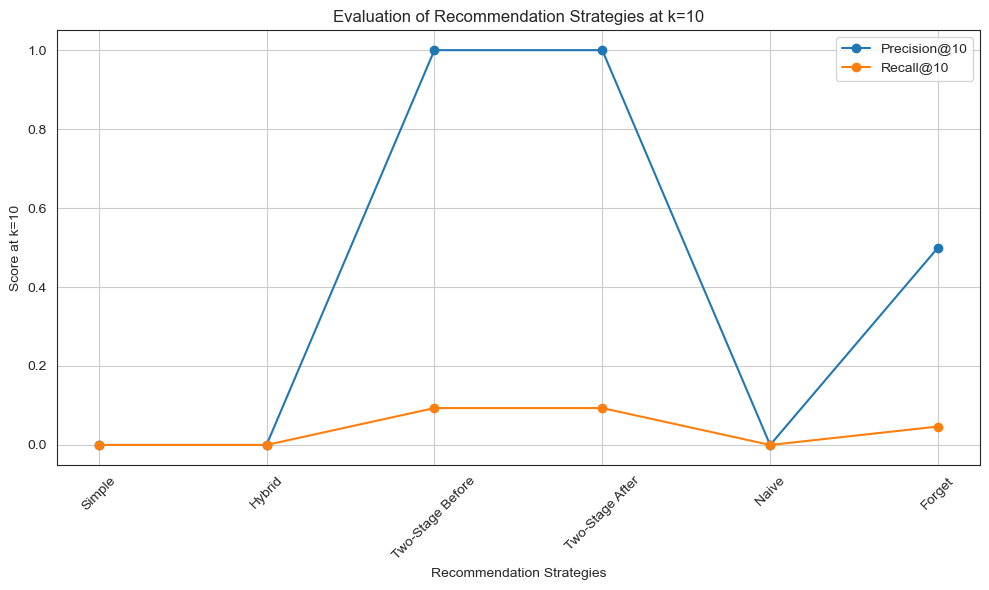


Evaluation Results:
Simple -> Precision@5: 0.0000, Recall@5: 0.0000
Hybrid -> Precision@5: 0.0000, Recall@5: 0.0000
Two-Stage Before -> Precision@5: 1.0000, Recall@5: 0.0935
Two-Stage After -> Precision@5: 1.0000, Recall@5: 0.0935
Naive -> Precision@5: 0.0000, Recall@5: 0.0000
Forget -> Precision@5: 0.5000, Recall@5: 0.0467


In [8151]:
recommended_items_dict = {
    'Simple': recommended_items_simple, 
    'Hybrid': recommended_items_hybrid,  
    'Two-Stage Before': before_recommendations_test,  
    'Two-Stage After': after_recommendations_test,  
    'Naive': recommended_items_naive,  
    'Forget': recommended_items_forget   
}

# results
evaluation_results = evaluate_recommendation_strategies(recommended_items_dict, actual_purchases, k=10)
print("\nEvaluation Results:")
for strategy, precision, recall in zip(evaluation_results['Strategies'], evaluation_results['Precision@k'], evaluation_results['Recall@k']):
    print(f"{strategy} -> Precision@5: {precision:.4f}, Recall@5: {recall:.4f}")

``Precision`` measures the accuracy of the recommendations. Specifically, Precision@5 = 1.0 means that all of the top 5 recommended items are correct, i.e., they match the items that the user has actually purchased.

``Recall`` measures the ability of the recommendation system to capture all the relevant items that the user has purchased. Specifically, Recall@5 = 0.027 means that, even though the system's top 5 recommendations may be highly accurate, they only capture a very small fraction (2.7%) of the total products the user has purchased.

`All clients results`

In [ ]:
# Initialize an empty list to store evaluation results for all clients
all_client_results = []

def evaluate_all_clients_recommendation_strategies(client_id, recommended_items_dict, actual_purchases, k=5): 
    """
    Evaluates multiple recommendation strategies and stores Precision@k and Recall@k for each client.
    
    Parameters:
    - client_id (str or int): The unique identifier for the client.
    - recommended_items_dict (dict): A dictionary where keys are strategy names and values are lists of recommended items.
    - actual_purchases (list): The list of products the client has actually purchased.
    - k (int): The number of top recommendations to consider for evaluation.
    
    Returns:
    - A dictionary containing the evaluation results (Precision and Recall for each strategy) for the given client.
    """
    # dictionaries to store data
    precision_scores = []
    recall_scores = []
    strategy_names = []

    # iterate through each recommendation strategy
    for strategy, recommended_items in recommended_items_dict.items():
        
        # validity check for recommendations
        if not recommended_items:
            #print(f"No recommendations for {strategy}. Skipping...")
            continue

        # calculate Precision@k and Recall@k for the current strategy
        precision_at_k = calculate_precision_at_k(recommended_items, actual_purchases, k)
        recall_at_k = calculate_recall_at_k(recommended_items, actual_purchases, k)
        
        # store results
        strategy_names.append(strategy)
        precision_scores.append(precision_at_k)
        recall_scores.append(recall_at_k)
        
    #print(f"Actual purchases: {actual_purchases}")
    

    # results
    client_results = {'Client ID': client_id}
    for strategy, precision, recall in zip(strategy_names, precision_scores, recall_scores):
        client_results[f'{strategy} Precision@{k}'] = precision
        client_results[f'{strategy} Recall@{k}'] = recall
    
    # append
    all_client_results.append(client_results)

    return client_results



In [ ]:

'''
actual_purchases = get_actual_purchases(test_df, set_client_id, test_start_date)
recommended_items_dict = {
    'Simple': recommended_items_simple, 
    'Hybrid': recommended_items_hybrid,  
    'Two-Stage Before': before_recommendations_test,  
    'Two-Stage After': after_recommendations_test,  
    'Naive': recommended_items_naive,  
    'Forget': recommended_items_forget   
}


client_results = evaluate_all_clients_recommendation_strategies(set_client_id, recommended_items_dict, actual_purchases, k=10)
#print(f"Results for client {set_client_id}:")
#print(client_results)


evaluation_df = pd.concat([evaluation_df, pd.DataFrame([client_results])], ignore_index=True)'''


In [ ]:
#len(evaluation_df)

150

In [ ]:
#evaluation_df.describe()

,Client ID,Simple Precision@10,Simple Recall@10,Hybrid Precision@10,Hybrid Recall@10,Two-Stage Before Precision@10,Two-Stage Before Recall@10,Two-Stage After Precision@10,Two-Stage After Recall@10,Naive Precision@10,Naive Recall@10,Forget Precision@10,Forget Recall@10
count,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,2.101076e+08,0.015333,0.002821,0.017333,0.002741,0.742667,0.162129,0.345333,0.069736,0.013333,0.002781,0.461333,0.105166
std,1.727656e+04,0.042940,0.011573,0.042956,0.008458,0.185496,0.158732,0.271606,0.098512,0.037839,0.011467,0.094682,0.110850
min,2.101002e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.101033e+08,0.000000,0.000000,0.000000,0.000000,0.600000,0.065467,0.100000,0.019093,0.000000,0.000000,0.500000,0.038481
50%,2.101050e+08,0.000000,0.000000,0.000000,0.000000,0.800000,0.118824,0.300000,0.036172,0.000000,0.000000,0.500000,0.070299
75%,2.101058e+08,0.000000,0.000000,0.000000,0.000000,0.900000,0.179487,0.500000,0.076923,0.000000,0.000000,0.500000,0.123512
max,2.101999e+08,0.300000,0.100000,0.200000,0.055556,1.000000,1.000000,1.000000,0.615385,0.200000,0.100000,0.500000,0.625000


In [ ]:
#precision_df = evaluation_df.loc[:, evaluation_df.columns.str.contains("Precision")]
#precision_df.describe()

,Simple Precision@10,Hybrid Precision@10,Two-Stage Before Precision@10,Two-Stage After Precision@10,Naive Precision@10,Forget Precision@10
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.015333,0.017333,0.742667,0.345333,0.013333,0.461333
std,0.042940,0.042956,0.185496,0.271606,0.037839,0.094682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.600000,0.100000,0.000000,0.500000
50%,0.000000,0.000000,0.800000,0.300000,0.000000,0.500000
75%,0.000000,0.000000,0.900000,0.500000,0.000000,0.500000
max,0.300000,0.200000,1.000000,1.000000,0.200000,0.500000
